<a href="https://colab.research.google.com/github/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/CycleGAN_Exercise_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/XY_season_images.png?raw=1' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/horse2zebra.jpg?raw=1' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
!wget --no-check-certificate --no-proxy 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip'

--2020-07-21 07:10:21--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.12.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.12.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  16.2MB/s    in 9.2s    

2020-07-21 07:10:31 (13.9 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [2]:
!unzip -o summer2winter-yosemite.zip

Streaming output truncated to the last 5000 lines.
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 16:14:33.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 16:14:33.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 19:37:52.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 19:37:52.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-03 20:17:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-03 20:17:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 13:38:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 13:38:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 19:59:13.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 19:59:13.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-05 06:09:05.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer

In [3]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [4]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [5]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

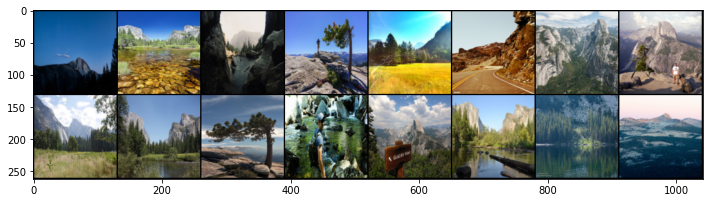

In [6]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

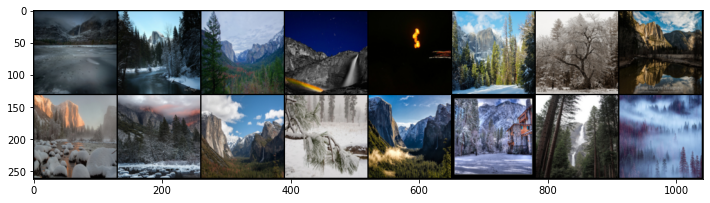

In [7]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0118)
Max:  tensor(0.7686)


In [9]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [10]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9765)
Scaled max:  tensor(0.5373)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/discriminator_layers.png?raw=1' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        # 128x128x3
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 64x64x64
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 32x32x128
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 16x16x256
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 8x8x512
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=1, bias=False)
        # self.conv5 = nn.Conv2d(512, 1, 8, stride=1, padding=0, bias=False)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # define feedforward behavior
        x = self.dropout(x)
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.conv5(x)
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/cyclegan_generator_ex.png?raw=1' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/resnet_50.png?raw=1' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/resnet_block.png?raw=1' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [13]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3

        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        x = F.relu(self.conv1(x))
        x = x + self.conv2(x)
        return x
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [14]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [15]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        self.conv_dim = conv_dim
        self.n_res_blocks = n_res_blocks

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        # 128x128x3
        self.conv1 = conv(3, conv_dim, 4)
        # 64x64x64
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 32x32x128
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 16x16x256

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_block_list = []
        for layer in range(n_res_blocks):
            res_block_list.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*res_block_list)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        # 16x16x256
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        # 32x32x128
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # 64x64x64
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        # 128x128x3

        self.tanh = nn.Tanh()

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.res_blocks(x)
        x = self.dropout(x)
        x = F.relu(self.deconv1(x))
        x = self.dropout(x)
        x = F.relu(self.deconv2(x))
        x = self.dropout(x)
        x = self.tanh(self.deconv3(x))

        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [16]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [17]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [18]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/CycleGAN_loss.png?raw=1'/>

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/reconstruction_error.png?raw=1'/>

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [19]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [20]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/cycle_consistency_ex.png?raw=1' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [22]:
%cd '/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/cycle-gan/'

#import helper.py
import imp 
helper = imp.new_module('helpers')
exec(open("./helpers.py").read(), helper.__dict__)

/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/cycle-gan


In [23]:
# import save code
from helpers import save_samples, checkpoint

In [24]:
%cd '/content/'

/content


In [25]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        # print('images_X.size()', images_X.size())
        # print('out_x.size()', out_x.size())
        # print('D_X_real_loss.size()', D_X_real_loss.size())
        # print('D_X_real_loss', D_X_real_loss)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        # print('images_Y.size()', images_Y.size())
        # print('fake_X.size()', fake_X.size())

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        # print('fake_X.size()', fake_X.size())
        # print('out_x.size()', out_x.size())
        # print('D_X_fake_loss.size()', D_X_fake_loss.size())
        # print('D_X_fake_loss', D_X_fake_loss)
        # break

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [26]:
%mkdir 'samples_cyclegan'

In [27]:
n_epochs = 10000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/10000] | d_X_loss: 0.4986 | d_Y_loss: 0.5322 | g_total_loss: 10.2665
Epoch [   20/10000] | d_X_loss: 0.4058 | d_Y_loss: 0.4590 | g_total_loss: 8.9992
Epoch [   30/10000] | d_X_loss: 0.5072 | d_Y_loss: 0.3883 | g_total_loss: 7.6591
Epoch [   40/10000] | d_X_loss: 0.3316 | d_Y_loss: 0.3704 | g_total_loss: 7.1887
Epoch [   50/10000] | d_X_loss: 0.3629 | d_Y_loss: 0.4353 | g_total_loss: 6.9169
Epoch [   60/10000] | d_X_loss: 1.0651 | d_Y_loss: 0.2658 | g_total_loss: 7.2561
Epoch [   70/10000] | d_X_loss: 0.3125 | d_Y_loss: 0.3111 | g_total_loss: 8.3060
Epoch [   80/10000] | d_X_loss: 0.4554 | d_Y_loss: 0.3982 | g_total_loss: 6.9570
Epoch [   90/10000] | d_X_loss: 0.2281 | d_Y_loss: 0.3198 | g_total_loss: 7.3972


Epoch [  100/10000] | d_X_loss: 0.3246 | d_Y_loss: 0.3975 | g_total_loss: 6.5780


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/10000] | d_X_loss: 0.5283 | d_Y_loss: 0.4389 | g_total_loss: 6.2330
Epoch [  120/10000] | d_X_loss: 0.3117 | d_Y_loss: 0.4088 | g_total_loss: 6.3730
Epoch [  130/10000] | d_X_loss: 0.5544 | d_Y_loss: 0.4675 | g_total_loss: 6.4244
Epoch [  140/10000] | d_X_loss: 0.1951 | d_Y_loss: 0.3038 | g_total_loss: 6.1199
Epoch [  150/10000] | d_X_loss: 0.5238 | d_Y_loss: 0.3953 | g_total_loss: 6.4328
Epoch [  160/10000] | d_X_loss: 0.4878 | d_Y_loss: 0.4601 | g_total_loss: 6.7702
Epoch [  170/10000] | d_X_loss: 0.3919 | d_Y_loss: 0.8150 | g_total_loss: 5.8266
Epoch [  180/10000] | d_X_loss: 0.5676 | d_Y_loss: 0.2040 | g_total_loss: 6.3616
Epoch [  190/10000] | d_X_loss: 0.5781 | d_Y_loss: 0.5879 | g_total_loss: 5.7621


Epoch [  200/10000] | d_X_loss: 0.4751 | d_Y_loss: 0.7598 | g_total_loss: 5.9439


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/10000] | d_X_loss: 0.5365 | d_Y_loss: 0.5498 | g_total_loss: 5.8878
Epoch [  220/10000] | d_X_loss: 0.4266 | d_Y_loss: 0.3319 | g_total_loss: 6.0477
Epoch [  230/10000] | d_X_loss: 0.3729 | d_Y_loss: 0.3272 | g_total_loss: 6.1376
Epoch [  240/10000] | d_X_loss: 0.4327 | d_Y_loss: 0.3303 | g_total_loss: 5.7197
Epoch [  250/10000] | d_X_loss: 1.1880 | d_Y_loss: 0.3063 | g_total_loss: 5.5543
Epoch [  260/10000] | d_X_loss: 0.3229 | d_Y_loss: 0.6234 | g_total_loss: 5.3316
Epoch [  270/10000] | d_X_loss: 0.7537 | d_Y_loss: 0.5425 | g_total_loss: 6.4972
Epoch [  280/10000] | d_X_loss: 0.4466 | d_Y_loss: 0.5210 | g_total_loss: 5.5532
Epoch [  290/10000] | d_X_loss: 0.5753 | d_Y_loss: 0.4800 | g_total_loss: 5.4794


Epoch [  300/10000] | d_X_loss: 0.5233 | d_Y_loss: 0.3983 | g_total_loss: 5.2069


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/10000] | d_X_loss: 0.4005 | d_Y_loss: 0.5447 | g_total_loss: 5.6422
Epoch [  320/10000] | d_X_loss: 0.5317 | d_Y_loss: 0.5019 | g_total_loss: 5.2871
Epoch [  330/10000] | d_X_loss: 0.3975 | d_Y_loss: 0.4317 | g_total_loss: 5.2170
Epoch [  340/10000] | d_X_loss: 0.3143 | d_Y_loss: 0.4937 | g_total_loss: 5.7872
Epoch [  350/10000] | d_X_loss: 0.4088 | d_Y_loss: 0.4685 | g_total_loss: 6.6442
Epoch [  360/10000] | d_X_loss: 0.3062 | d_Y_loss: 0.3386 | g_total_loss: 5.2722
Epoch [  370/10000] | d_X_loss: 0.3621 | d_Y_loss: 0.3676 | g_total_loss: 6.6851
Epoch [  380/10000] | d_X_loss: 1.0164 | d_Y_loss: 0.3498 | g_total_loss: 5.3719
Epoch [  390/10000] | d_X_loss: 0.4395 | d_Y_loss: 0.4528 | g_total_loss: 5.8543


Epoch [  400/10000] | d_X_loss: 0.5421 | d_Y_loss: 0.4691 | g_total_loss: 5.0665


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/10000] | d_X_loss: 0.4928 | d_Y_loss: 0.4434 | g_total_loss: 5.0808
Epoch [  420/10000] | d_X_loss: 0.2758 | d_Y_loss: 0.2351 | g_total_loss: 6.4590
Epoch [  430/10000] | d_X_loss: 0.4678 | d_Y_loss: 0.3414 | g_total_loss: 5.8387
Epoch [  440/10000] | d_X_loss: 0.3916 | d_Y_loss: 0.6555 | g_total_loss: 7.7915
Epoch [  450/10000] | d_X_loss: 0.2982 | d_Y_loss: 0.4141 | g_total_loss: 5.7569
Epoch [  460/10000] | d_X_loss: 0.4698 | d_Y_loss: 0.3441 | g_total_loss: 5.9759
Epoch [  470/10000] | d_X_loss: 0.5284 | d_Y_loss: 0.4581 | g_total_loss: 5.5195
Epoch [  480/10000] | d_X_loss: 0.3394 | d_Y_loss: 0.4616 | g_total_loss: 4.9528
Epoch [  490/10000] | d_X_loss: 0.4800 | d_Y_loss: 0.4315 | g_total_loss: 5.3906


Epoch [  500/10000] | d_X_loss: 0.4168 | d_Y_loss: 0.4450 | g_total_loss: 5.4532


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/10000] | d_X_loss: 0.4837 | d_Y_loss: 0.3152 | g_total_loss: 5.3332
Epoch [  520/10000] | d_X_loss: 0.5059 | d_Y_loss: 0.3470 | g_total_loss: 5.6440
Epoch [  530/10000] | d_X_loss: 0.3154 | d_Y_loss: 0.4393 | g_total_loss: 5.4192
Epoch [  540/10000] | d_X_loss: 0.3889 | d_Y_loss: 0.3714 | g_total_loss: 5.9715
Epoch [  550/10000] | d_X_loss: 0.3322 | d_Y_loss: 0.4119 | g_total_loss: 5.6153
Epoch [  560/10000] | d_X_loss: 0.4400 | d_Y_loss: 0.4162 | g_total_loss: 5.3364
Epoch [  570/10000] | d_X_loss: 0.5539 | d_Y_loss: 0.4464 | g_total_loss: 5.5120
Epoch [  580/10000] | d_X_loss: 0.4302 | d_Y_loss: 0.3513 | g_total_loss: 6.0131
Epoch [  590/10000] | d_X_loss: 0.4350 | d_Y_loss: 0.4608 | g_total_loss: 5.3847


Epoch [  600/10000] | d_X_loss: 0.3642 | d_Y_loss: 0.2778 | g_total_loss: 5.1289


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/10000] | d_X_loss: 0.5984 | d_Y_loss: 0.4312 | g_total_loss: 4.9190
Epoch [  620/10000] | d_X_loss: 0.4039 | d_Y_loss: 0.3116 | g_total_loss: 6.0611
Epoch [  630/10000] | d_X_loss: 0.3339 | d_Y_loss: 0.2098 | g_total_loss: 5.8917
Epoch [  640/10000] | d_X_loss: 0.6783 | d_Y_loss: 0.4690 | g_total_loss: 4.8196
Epoch [  650/10000] | d_X_loss: 0.2539 | d_Y_loss: 0.2147 | g_total_loss: 5.7029
Epoch [  660/10000] | d_X_loss: 0.5209 | d_Y_loss: 0.8088 | g_total_loss: 6.4270
Epoch [  670/10000] | d_X_loss: 0.3222 | d_Y_loss: 0.3623 | g_total_loss: 5.0692
Epoch [  680/10000] | d_X_loss: 0.4942 | d_Y_loss: 0.3572 | g_total_loss: 4.8244
Epoch [  690/10000] | d_X_loss: 0.5520 | d_Y_loss: 0.4305 | g_total_loss: 5.1567


Epoch [  700/10000] | d_X_loss: 0.4356 | d_Y_loss: 0.4349 | g_total_loss: 4.9778


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/10000] | d_X_loss: 0.3289 | d_Y_loss: 0.3595 | g_total_loss: 5.0558
Epoch [  720/10000] | d_X_loss: 0.4748 | d_Y_loss: 0.3576 | g_total_loss: 4.6039
Epoch [  730/10000] | d_X_loss: 0.4674 | d_Y_loss: 0.3536 | g_total_loss: 4.6061
Epoch [  740/10000] | d_X_loss: 0.3715 | d_Y_loss: 0.5014 | g_total_loss: 5.3306
Epoch [  750/10000] | d_X_loss: 0.4224 | d_Y_loss: 0.5122 | g_total_loss: 4.6626
Epoch [  760/10000] | d_X_loss: 0.4443 | d_Y_loss: 0.3970 | g_total_loss: 6.2477
Epoch [  770/10000] | d_X_loss: 0.1595 | d_Y_loss: 0.3432 | g_total_loss: 5.9406
Epoch [  780/10000] | d_X_loss: 0.4366 | d_Y_loss: 0.5485 | g_total_loss: 5.2845
Epoch [  790/10000] | d_X_loss: 0.8448 | d_Y_loss: 0.2735 | g_total_loss: 4.9141


Epoch [  800/10000] | d_X_loss: 0.4226 | d_Y_loss: 0.3813 | g_total_loss: 5.3300


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/10000] | d_X_loss: 0.5345 | d_Y_loss: 0.4136 | g_total_loss: 5.0029
Epoch [  820/10000] | d_X_loss: 0.3808 | d_Y_loss: 0.2629 | g_total_loss: 5.6329
Epoch [  830/10000] | d_X_loss: 0.4203 | d_Y_loss: 0.4358 | g_total_loss: 5.9068
Epoch [  840/10000] | d_X_loss: 0.3863 | d_Y_loss: 0.4109 | g_total_loss: 5.4260
Epoch [  850/10000] | d_X_loss: 0.4939 | d_Y_loss: 0.3930 | g_total_loss: 4.8874
Epoch [  860/10000] | d_X_loss: 0.2723 | d_Y_loss: 0.3173 | g_total_loss: 5.5160
Epoch [  870/10000] | d_X_loss: 0.5642 | d_Y_loss: 0.3421 | g_total_loss: 4.8043
Epoch [  880/10000] | d_X_loss: 0.3144 | d_Y_loss: 0.5426 | g_total_loss: 4.6843
Epoch [  890/10000] | d_X_loss: 0.3696 | d_Y_loss: 0.2793 | g_total_loss: 4.9974


Epoch [  900/10000] | d_X_loss: 0.4677 | d_Y_loss: 0.3810 | g_total_loss: 4.5799


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/10000] | d_X_loss: 0.4841 | d_Y_loss: 0.3382 | g_total_loss: 5.6298
Epoch [  920/10000] | d_X_loss: 0.3659 | d_Y_loss: 0.1800 | g_total_loss: 4.7251
Epoch [  930/10000] | d_X_loss: 0.5823 | d_Y_loss: 0.2344 | g_total_loss: 6.3541
Epoch [  940/10000] | d_X_loss: 0.3787 | d_Y_loss: 0.3742 | g_total_loss: 6.6082
Epoch [  950/10000] | d_X_loss: 0.4941 | d_Y_loss: 0.5522 | g_total_loss: 4.9412
Epoch [  960/10000] | d_X_loss: 0.5238 | d_Y_loss: 0.5008 | g_total_loss: 5.3943
Epoch [  970/10000] | d_X_loss: 0.4393 | d_Y_loss: 0.3201 | g_total_loss: 5.3244
Epoch [  980/10000] | d_X_loss: 0.4251 | d_Y_loss: 0.2972 | g_total_loss: 5.2764
Epoch [  990/10000] | d_X_loss: 0.3668 | d_Y_loss: 0.4979 | g_total_loss: 5.3452


Epoch [ 1000/10000] | d_X_loss: 0.4483 | d_Y_loss: 0.4668 | g_total_loss: 4.5218


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/10000] | d_X_loss: 0.4746 | d_Y_loss: 0.3724 | g_total_loss: 4.4129
Epoch [ 1020/10000] | d_X_loss: 0.5880 | d_Y_loss: 0.5017 | g_total_loss: 4.4773
Epoch [ 1030/10000] | d_X_loss: 0.4161 | d_Y_loss: 0.3640 | g_total_loss: 5.1893
Epoch [ 1040/10000] | d_X_loss: 0.4322 | d_Y_loss: 0.5412 | g_total_loss: 5.2703
Epoch [ 1050/10000] | d_X_loss: 0.4574 | d_Y_loss: 0.4717 | g_total_loss: 4.0844
Epoch [ 1060/10000] | d_X_loss: 0.4724 | d_Y_loss: 0.3742 | g_total_loss: 4.7682
Epoch [ 1070/10000] | d_X_loss: 0.3908 | d_Y_loss: 0.3683 | g_total_loss: 4.4713
Epoch [ 1080/10000] | d_X_loss: 0.3061 | d_Y_loss: 0.7746 | g_total_loss: 4.7422
Epoch [ 1090/10000] | d_X_loss: 0.4242 | d_Y_loss: 0.3818 | g_total_loss: 4.4927


Epoch [ 1100/10000] | d_X_loss: 0.3563 | d_Y_loss: 0.3992 | g_total_loss: 5.4825


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/10000] | d_X_loss: 0.5134 | d_Y_loss: 0.4695 | g_total_loss: 4.2806
Epoch [ 1120/10000] | d_X_loss: 0.3368 | d_Y_loss: 0.3562 | g_total_loss: 5.0184
Epoch [ 1130/10000] | d_X_loss: 0.2857 | d_Y_loss: 0.4973 | g_total_loss: 4.6451
Epoch [ 1140/10000] | d_X_loss: 0.3466 | d_Y_loss: 0.4325 | g_total_loss: 5.0707
Epoch [ 1150/10000] | d_X_loss: 0.4310 | d_Y_loss: 0.4357 | g_total_loss: 4.3717
Epoch [ 1160/10000] | d_X_loss: 0.4273 | d_Y_loss: 0.3570 | g_total_loss: 5.1029
Epoch [ 1170/10000] | d_X_loss: 0.3456 | d_Y_loss: 0.2767 | g_total_loss: 4.7015
Epoch [ 1180/10000] | d_X_loss: 0.5747 | d_Y_loss: 0.5199 | g_total_loss: 4.6529
Epoch [ 1190/10000] | d_X_loss: 0.2869 | d_Y_loss: 0.3450 | g_total_loss: 5.1924


Epoch [ 1200/10000] | d_X_loss: 0.2791 | d_Y_loss: 0.3450 | g_total_loss: 5.2113


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/10000] | d_X_loss: 0.3785 | d_Y_loss: 0.3841 | g_total_loss: 5.0641
Epoch [ 1220/10000] | d_X_loss: 0.3576 | d_Y_loss: 0.6612 | g_total_loss: 4.5943
Epoch [ 1230/10000] | d_X_loss: 0.3431 | d_Y_loss: 0.3298 | g_total_loss: 4.6036
Epoch [ 1240/10000] | d_X_loss: 0.3781 | d_Y_loss: 0.1199 | g_total_loss: 5.3902
Epoch [ 1250/10000] | d_X_loss: 0.5674 | d_Y_loss: 0.3145 | g_total_loss: 4.7602
Epoch [ 1260/10000] | d_X_loss: 0.4158 | d_Y_loss: 0.4361 | g_total_loss: 5.0785
Epoch [ 1270/10000] | d_X_loss: 0.2818 | d_Y_loss: 0.3590 | g_total_loss: 4.7971
Epoch [ 1280/10000] | d_X_loss: 0.2514 | d_Y_loss: 0.5016 | g_total_loss: 5.7337
Epoch [ 1290/10000] | d_X_loss: 0.5838 | d_Y_loss: 0.4120 | g_total_loss: 4.7172


Epoch [ 1300/10000] | d_X_loss: 0.3578 | d_Y_loss: 0.4755 | g_total_loss: 4.8124


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/10000] | d_X_loss: 0.4405 | d_Y_loss: 0.4328 | g_total_loss: 4.5635
Epoch [ 1320/10000] | d_X_loss: 0.5535 | d_Y_loss: 0.3201 | g_total_loss: 4.3752
Epoch [ 1330/10000] | d_X_loss: 0.2994 | d_Y_loss: 0.3653 | g_total_loss: 5.1125
Epoch [ 1340/10000] | d_X_loss: 0.5218 | d_Y_loss: 0.1619 | g_total_loss: 5.4257
Epoch [ 1350/10000] | d_X_loss: 0.4201 | d_Y_loss: 0.4275 | g_total_loss: 5.5087
Epoch [ 1360/10000] | d_X_loss: 0.4476 | d_Y_loss: 0.4292 | g_total_loss: 4.7445
Epoch [ 1370/10000] | d_X_loss: 0.3862 | d_Y_loss: 0.3349 | g_total_loss: 5.2949
Epoch [ 1380/10000] | d_X_loss: 0.3393 | d_Y_loss: 0.3455 | g_total_loss: 5.0904
Epoch [ 1390/10000] | d_X_loss: 0.3630 | d_Y_loss: 0.3142 | g_total_loss: 4.9793


Epoch [ 1400/10000] | d_X_loss: 0.5012 | d_Y_loss: 0.4672 | g_total_loss: 4.9661


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/10000] | d_X_loss: 0.3217 | d_Y_loss: 0.6362 | g_total_loss: 5.8735
Epoch [ 1420/10000] | d_X_loss: 0.3574 | d_Y_loss: 0.3168 | g_total_loss: 4.4620
Epoch [ 1430/10000] | d_X_loss: 0.3046 | d_Y_loss: 0.4457 | g_total_loss: 4.6974
Epoch [ 1440/10000] | d_X_loss: 1.1500 | d_Y_loss: 0.3562 | g_total_loss: 6.0852
Epoch [ 1450/10000] | d_X_loss: 0.3815 | d_Y_loss: 0.3435 | g_total_loss: 4.5678
Epoch [ 1460/10000] | d_X_loss: 0.4230 | d_Y_loss: 0.3273 | g_total_loss: 4.7839
Epoch [ 1470/10000] | d_X_loss: 0.4606 | d_Y_loss: 0.3382 | g_total_loss: 4.9251
Epoch [ 1480/10000] | d_X_loss: 0.3343 | d_Y_loss: 0.2383 | g_total_loss: 5.7364
Epoch [ 1490/10000] | d_X_loss: 0.1722 | d_Y_loss: 0.5675 | g_total_loss: 5.3077


Epoch [ 1500/10000] | d_X_loss: 0.5517 | d_Y_loss: 0.3614 | g_total_loss: 4.5359


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/10000] | d_X_loss: 0.2839 | d_Y_loss: 0.3576 | g_total_loss: 4.5357
Epoch [ 1520/10000] | d_X_loss: 0.2846 | d_Y_loss: 0.3698 | g_total_loss: 4.7456
Epoch [ 1530/10000] | d_X_loss: 0.5562 | d_Y_loss: 0.3015 | g_total_loss: 4.8932
Epoch [ 1540/10000] | d_X_loss: 0.5091 | d_Y_loss: 0.4209 | g_total_loss: 5.6289
Epoch [ 1550/10000] | d_X_loss: 0.1677 | d_Y_loss: 0.3446 | g_total_loss: 5.3898
Epoch [ 1560/10000] | d_X_loss: 0.3736 | d_Y_loss: 0.2467 | g_total_loss: 4.9610
Epoch [ 1570/10000] | d_X_loss: 0.2284 | d_Y_loss: 0.4595 | g_total_loss: 5.4143
Epoch [ 1580/10000] | d_X_loss: 0.3346 | d_Y_loss: 0.2772 | g_total_loss: 4.6036
Epoch [ 1590/10000] | d_X_loss: 0.3940 | d_Y_loss: 0.3965 | g_total_loss: 5.0323


Epoch [ 1600/10000] | d_X_loss: 0.1887 | d_Y_loss: 0.3459 | g_total_loss: 5.8050


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/10000] | d_X_loss: 0.3315 | d_Y_loss: 0.3450 | g_total_loss: 4.5535
Epoch [ 1620/10000] | d_X_loss: 0.5104 | d_Y_loss: 0.4697 | g_total_loss: 4.7289
Epoch [ 1630/10000] | d_X_loss: 0.2405 | d_Y_loss: 0.3333 | g_total_loss: 5.2543
Epoch [ 1640/10000] | d_X_loss: 0.1662 | d_Y_loss: 0.3374 | g_total_loss: 5.7306
Epoch [ 1650/10000] | d_X_loss: 0.4438 | d_Y_loss: 0.4428 | g_total_loss: 5.3449
Epoch [ 1660/10000] | d_X_loss: 0.4738 | d_Y_loss: 0.5396 | g_total_loss: 4.0943
Epoch [ 1670/10000] | d_X_loss: 0.5059 | d_Y_loss: 0.6629 | g_total_loss: 4.0702
Epoch [ 1680/10000] | d_X_loss: 0.4776 | d_Y_loss: 0.4123 | g_total_loss: 4.9412
Epoch [ 1690/10000] | d_X_loss: 0.4052 | d_Y_loss: 0.4220 | g_total_loss: 4.1952


Epoch [ 1700/10000] | d_X_loss: 0.2906 | d_Y_loss: 0.4001 | g_total_loss: 4.1669


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/10000] | d_X_loss: 0.3867 | d_Y_loss: 0.4298 | g_total_loss: 4.2351
Epoch [ 1720/10000] | d_X_loss: 0.3273 | d_Y_loss: 0.2539 | g_total_loss: 5.2297
Epoch [ 1730/10000] | d_X_loss: 0.2856 | d_Y_loss: 0.4499 | g_total_loss: 4.4832
Epoch [ 1740/10000] | d_X_loss: 0.3339 | d_Y_loss: 0.4468 | g_total_loss: 4.6321
Epoch [ 1750/10000] | d_X_loss: 0.2199 | d_Y_loss: 0.3687 | g_total_loss: 5.0728
Epoch [ 1760/10000] | d_X_loss: 0.3865 | d_Y_loss: 0.3221 | g_total_loss: 4.7338
Epoch [ 1770/10000] | d_X_loss: 0.3990 | d_Y_loss: 0.4790 | g_total_loss: 4.5951
Epoch [ 1780/10000] | d_X_loss: 0.4337 | d_Y_loss: 0.3934 | g_total_loss: 4.6873
Epoch [ 1790/10000] | d_X_loss: 0.3461 | d_Y_loss: 0.3746 | g_total_loss: 4.3711


Epoch [ 1800/10000] | d_X_loss: 0.2570 | d_Y_loss: 0.3690 | g_total_loss: 5.1999


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/10000] | d_X_loss: 0.3090 | d_Y_loss: 0.2694 | g_total_loss: 4.9511
Epoch [ 1820/10000] | d_X_loss: 0.3481 | d_Y_loss: 0.4274 | g_total_loss: 4.7251
Epoch [ 1830/10000] | d_X_loss: 0.7975 | d_Y_loss: 0.3412 | g_total_loss: 4.2221
Epoch [ 1840/10000] | d_X_loss: 0.2786 | d_Y_loss: 0.3545 | g_total_loss: 5.1506
Epoch [ 1850/10000] | d_X_loss: 0.4359 | d_Y_loss: 0.3056 | g_total_loss: 5.5380
Epoch [ 1860/10000] | d_X_loss: 0.6437 | d_Y_loss: 0.4336 | g_total_loss: 4.5141
Epoch [ 1870/10000] | d_X_loss: 0.3599 | d_Y_loss: 0.5004 | g_total_loss: 4.4537
Epoch [ 1880/10000] | d_X_loss: 0.3795 | d_Y_loss: 0.3977 | g_total_loss: 4.5800
Epoch [ 1890/10000] | d_X_loss: 0.2692 | d_Y_loss: 0.5796 | g_total_loss: 6.3149


Epoch [ 1900/10000] | d_X_loss: 0.4796 | d_Y_loss: 0.3967 | g_total_loss: 4.3427


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/10000] | d_X_loss: 0.5950 | d_Y_loss: 0.3249 | g_total_loss: 4.2677
Epoch [ 1920/10000] | d_X_loss: 0.3323 | d_Y_loss: 0.2635 | g_total_loss: 4.6912
Epoch [ 1930/10000] | d_X_loss: 0.3196 | d_Y_loss: 0.2650 | g_total_loss: 5.0276
Epoch [ 1940/10000] | d_X_loss: 0.3860 | d_Y_loss: 0.5075 | g_total_loss: 4.5751
Epoch [ 1950/10000] | d_X_loss: 0.2706 | d_Y_loss: 0.5055 | g_total_loss: 4.5006
Epoch [ 1960/10000] | d_X_loss: 0.1783 | d_Y_loss: 0.4108 | g_total_loss: 4.9378
Epoch [ 1970/10000] | d_X_loss: 0.2210 | d_Y_loss: 0.3573 | g_total_loss: 5.1273
Epoch [ 1980/10000] | d_X_loss: 0.3414 | d_Y_loss: 0.4700 | g_total_loss: 4.4813
Epoch [ 1990/10000] | d_X_loss: 0.3095 | d_Y_loss: 0.4083 | g_total_loss: 4.7353


Epoch [ 2000/10000] | d_X_loss: 0.3090 | d_Y_loss: 0.4283 | g_total_loss: 5.4773


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/10000] | d_X_loss: 0.2628 | d_Y_loss: 0.3911 | g_total_loss: 4.8096
Epoch [ 2020/10000] | d_X_loss: 0.2364 | d_Y_loss: 0.4048 | g_total_loss: 5.9117
Epoch [ 2030/10000] | d_X_loss: 0.2274 | d_Y_loss: 0.3209 | g_total_loss: 5.1149
Epoch [ 2040/10000] | d_X_loss: 0.3270 | d_Y_loss: 0.5142 | g_total_loss: 4.1699
Epoch [ 2050/10000] | d_X_loss: 0.4841 | d_Y_loss: 0.3328 | g_total_loss: 4.5354
Epoch [ 2060/10000] | d_X_loss: 0.4003 | d_Y_loss: 0.2776 | g_total_loss: 5.6521
Epoch [ 2070/10000] | d_X_loss: 0.3959 | d_Y_loss: 0.2534 | g_total_loss: 4.2799
Epoch [ 2080/10000] | d_X_loss: 0.2460 | d_Y_loss: 0.4148 | g_total_loss: 5.1903
Epoch [ 2090/10000] | d_X_loss: 0.3209 | d_Y_loss: 0.3106 | g_total_loss: 4.7085


Epoch [ 2100/10000] | d_X_loss: 0.4397 | d_Y_loss: 0.3910 | g_total_loss: 4.2196


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/10000] | d_X_loss: 0.5120 | d_Y_loss: 0.3743 | g_total_loss: 4.5614
Epoch [ 2120/10000] | d_X_loss: 0.4424 | d_Y_loss: 0.4528 | g_total_loss: 4.9753
Epoch [ 2130/10000] | d_X_loss: 0.3096 | d_Y_loss: 0.3775 | g_total_loss: 4.8966
Epoch [ 2140/10000] | d_X_loss: 0.3411 | d_Y_loss: 0.4121 | g_total_loss: 4.5002
Epoch [ 2150/10000] | d_X_loss: 0.4087 | d_Y_loss: 0.2305 | g_total_loss: 6.0690
Epoch [ 2160/10000] | d_X_loss: 0.2325 | d_Y_loss: 0.3098 | g_total_loss: 5.3035
Epoch [ 2170/10000] | d_X_loss: 0.3107 | d_Y_loss: 0.3477 | g_total_loss: 5.3827
Epoch [ 2180/10000] | d_X_loss: 0.4241 | d_Y_loss: 0.3648 | g_total_loss: 4.8051
Epoch [ 2190/10000] | d_X_loss: 0.3021 | d_Y_loss: 0.2886 | g_total_loss: 4.5669


Epoch [ 2200/10000] | d_X_loss: 0.4914 | d_Y_loss: 0.3528 | g_total_loss: 4.4354


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/10000] | d_X_loss: 0.3724 | d_Y_loss: 0.3574 | g_total_loss: 4.8126
Epoch [ 2220/10000] | d_X_loss: 0.3246 | d_Y_loss: 0.3678 | g_total_loss: 4.4246
Epoch [ 2230/10000] | d_X_loss: 0.4498 | d_Y_loss: 0.5021 | g_total_loss: 4.4988
Epoch [ 2240/10000] | d_X_loss: 0.4913 | d_Y_loss: 0.5807 | g_total_loss: 4.0229
Epoch [ 2250/10000] | d_X_loss: 0.3100 | d_Y_loss: 0.3592 | g_total_loss: 4.4835
Epoch [ 2260/10000] | d_X_loss: 0.2274 | d_Y_loss: 0.3525 | g_total_loss: 4.5603
Epoch [ 2270/10000] | d_X_loss: 0.3580 | d_Y_loss: 0.3049 | g_total_loss: 5.0796
Epoch [ 2280/10000] | d_X_loss: 0.2677 | d_Y_loss: 0.2736 | g_total_loss: 4.8405
Epoch [ 2290/10000] | d_X_loss: 0.3872 | d_Y_loss: 0.2853 | g_total_loss: 4.7134


Epoch [ 2300/10000] | d_X_loss: 0.3908 | d_Y_loss: 0.3691 | g_total_loss: 4.2125


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/10000] | d_X_loss: 0.1902 | d_Y_loss: 0.2252 | g_total_loss: 5.7444
Epoch [ 2320/10000] | d_X_loss: 0.4365 | d_Y_loss: 0.2501 | g_total_loss: 5.4521
Epoch [ 2330/10000] | d_X_loss: 0.4452 | d_Y_loss: 0.3636 | g_total_loss: 4.2727
Epoch [ 2340/10000] | d_X_loss: 0.5023 | d_Y_loss: 0.2834 | g_total_loss: 4.9843
Epoch [ 2350/10000] | d_X_loss: 0.3586 | d_Y_loss: 0.3554 | g_total_loss: 5.2190
Epoch [ 2360/10000] | d_X_loss: 0.2448 | d_Y_loss: 0.1679 | g_total_loss: 5.7272
Epoch [ 2370/10000] | d_X_loss: 0.4296 | d_Y_loss: 0.3519 | g_total_loss: 4.7445
Epoch [ 2380/10000] | d_X_loss: 0.3152 | d_Y_loss: 0.1579 | g_total_loss: 5.9080
Epoch [ 2390/10000] | d_X_loss: 0.3486 | d_Y_loss: 0.3460 | g_total_loss: 4.7347


Epoch [ 2400/10000] | d_X_loss: 0.3066 | d_Y_loss: 0.2951 | g_total_loss: 4.9546


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/10000] | d_X_loss: 0.3428 | d_Y_loss: 0.3936 | g_total_loss: 5.3969
Epoch [ 2420/10000] | d_X_loss: 0.3225 | d_Y_loss: 0.4467 | g_total_loss: 5.4994
Epoch [ 2430/10000] | d_X_loss: 0.1999 | d_Y_loss: 0.2584 | g_total_loss: 5.2860
Epoch [ 2440/10000] | d_X_loss: 0.1966 | d_Y_loss: 0.3146 | g_total_loss: 5.7212
Epoch [ 2450/10000] | d_X_loss: 0.2925 | d_Y_loss: 0.3307 | g_total_loss: 5.5547
Epoch [ 2460/10000] | d_X_loss: 0.5443 | d_Y_loss: 0.5080 | g_total_loss: 5.6620
Epoch [ 2470/10000] | d_X_loss: 0.2924 | d_Y_loss: 0.3483 | g_total_loss: 5.0400
Epoch [ 2480/10000] | d_X_loss: 0.2209 | d_Y_loss: 0.5849 | g_total_loss: 4.8790
Epoch [ 2490/10000] | d_X_loss: 0.2369 | d_Y_loss: 0.4719 | g_total_loss: 4.7163


Epoch [ 2500/10000] | d_X_loss: 0.3591 | d_Y_loss: 0.6880 | g_total_loss: 4.4980


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/10000] | d_X_loss: 0.3839 | d_Y_loss: 0.3900 | g_total_loss: 4.7940
Epoch [ 2520/10000] | d_X_loss: 0.3004 | d_Y_loss: 0.3285 | g_total_loss: 4.4993
Epoch [ 2530/10000] | d_X_loss: 0.2093 | d_Y_loss: 0.2096 | g_total_loss: 5.3762
Epoch [ 2540/10000] | d_X_loss: 0.2211 | d_Y_loss: 0.4065 | g_total_loss: 4.5315
Epoch [ 2550/10000] | d_X_loss: 0.3038 | d_Y_loss: 0.4214 | g_total_loss: 4.8460
Epoch [ 2560/10000] | d_X_loss: 0.3886 | d_Y_loss: 0.4735 | g_total_loss: 4.2408
Epoch [ 2570/10000] | d_X_loss: 0.4358 | d_Y_loss: 0.4550 | g_total_loss: 4.6957
Epoch [ 2580/10000] | d_X_loss: 0.6520 | d_Y_loss: 0.3848 | g_total_loss: 4.7957
Epoch [ 2590/10000] | d_X_loss: 0.3792 | d_Y_loss: 0.4992 | g_total_loss: 4.5479


Epoch [ 2600/10000] | d_X_loss: 0.3327 | d_Y_loss: 0.3600 | g_total_loss: 4.6161


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/10000] | d_X_loss: 0.4088 | d_Y_loss: 0.3869 | g_total_loss: 4.3007
Epoch [ 2620/10000] | d_X_loss: 0.6434 | d_Y_loss: 0.3390 | g_total_loss: 4.3168
Epoch [ 2630/10000] | d_X_loss: 0.3931 | d_Y_loss: 0.3957 | g_total_loss: 4.7985
Epoch [ 2640/10000] | d_X_loss: 0.3426 | d_Y_loss: 0.3233 | g_total_loss: 4.6230
Epoch [ 2650/10000] | d_X_loss: 0.3662 | d_Y_loss: 0.3687 | g_total_loss: 4.4782
Epoch [ 2660/10000] | d_X_loss: 0.4601 | d_Y_loss: 0.4507 | g_total_loss: 4.5134
Epoch [ 2670/10000] | d_X_loss: 0.2790 | d_Y_loss: 0.3183 | g_total_loss: 4.6263
Epoch [ 2680/10000] | d_X_loss: 0.2202 | d_Y_loss: 0.2667 | g_total_loss: 5.0117
Epoch [ 2690/10000] | d_X_loss: 0.3561 | d_Y_loss: 0.4576 | g_total_loss: 4.4714


Epoch [ 2700/10000] | d_X_loss: 0.2399 | d_Y_loss: 0.5328 | g_total_loss: 4.9473


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/10000] | d_X_loss: 0.6314 | d_Y_loss: 0.3329 | g_total_loss: 4.5247
Epoch [ 2720/10000] | d_X_loss: 0.4031 | d_Y_loss: 0.4608 | g_total_loss: 4.2419
Epoch [ 2730/10000] | d_X_loss: 0.5415 | d_Y_loss: 0.2974 | g_total_loss: 4.5202
Epoch [ 2740/10000] | d_X_loss: 0.3508 | d_Y_loss: 0.3640 | g_total_loss: 4.2468
Epoch [ 2750/10000] | d_X_loss: 0.3445 | d_Y_loss: 0.4188 | g_total_loss: 4.8369
Epoch [ 2760/10000] | d_X_loss: 0.3965 | d_Y_loss: 0.3437 | g_total_loss: 4.4120
Epoch [ 2770/10000] | d_X_loss: 0.3301 | d_Y_loss: 0.3917 | g_total_loss: 4.3910
Epoch [ 2780/10000] | d_X_loss: 0.3434 | d_Y_loss: 0.5630 | g_total_loss: 4.2486
Epoch [ 2790/10000] | d_X_loss: 0.3475 | d_Y_loss: 0.4325 | g_total_loss: 4.6506


Epoch [ 2800/10000] | d_X_loss: 0.2694 | d_Y_loss: 0.3024 | g_total_loss: 4.3560


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/10000] | d_X_loss: 0.5571 | d_Y_loss: 0.2401 | g_total_loss: 4.5290
Epoch [ 2820/10000] | d_X_loss: 0.3747 | d_Y_loss: 0.2289 | g_total_loss: 4.3765
Epoch [ 2830/10000] | d_X_loss: 0.3584 | d_Y_loss: 0.3761 | g_total_loss: 4.5172
Epoch [ 2840/10000] | d_X_loss: 0.4318 | d_Y_loss: 0.4083 | g_total_loss: 4.4545
Epoch [ 2850/10000] | d_X_loss: 0.4015 | d_Y_loss: 0.3575 | g_total_loss: 4.2906
Epoch [ 2860/10000] | d_X_loss: 0.4251 | d_Y_loss: 0.4576 | g_total_loss: 4.4591
Epoch [ 2870/10000] | d_X_loss: 0.4757 | d_Y_loss: 0.2813 | g_total_loss: 4.4654
Epoch [ 2880/10000] | d_X_loss: 0.2772 | d_Y_loss: 0.3435 | g_total_loss: 4.3177
Epoch [ 2890/10000] | d_X_loss: 0.4597 | d_Y_loss: 0.3421 | g_total_loss: 4.2600


Epoch [ 2900/10000] | d_X_loss: 0.3673 | d_Y_loss: 0.5617 | g_total_loss: 4.5605


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/10000] | d_X_loss: 0.3637 | d_Y_loss: 0.2642 | g_total_loss: 4.2358
Epoch [ 2920/10000] | d_X_loss: 0.5169 | d_Y_loss: 0.4198 | g_total_loss: 4.3064
Epoch [ 2930/10000] | d_X_loss: 0.3134 | d_Y_loss: 0.3934 | g_total_loss: 4.5380
Epoch [ 2940/10000] | d_X_loss: 0.4590 | d_Y_loss: 0.4455 | g_total_loss: 4.5940
Epoch [ 2950/10000] | d_X_loss: 0.3489 | d_Y_loss: 0.3887 | g_total_loss: 4.4051
Epoch [ 2960/10000] | d_X_loss: 0.3611 | d_Y_loss: 0.6521 | g_total_loss: 4.3972
Epoch [ 2970/10000] | d_X_loss: 0.4116 | d_Y_loss: 0.3465 | g_total_loss: 4.7298
Epoch [ 2980/10000] | d_X_loss: 0.4037 | d_Y_loss: 0.2714 | g_total_loss: 4.3087
Epoch [ 2990/10000] | d_X_loss: 0.3742 | d_Y_loss: 0.3412 | g_total_loss: 4.7308


Epoch [ 3000/10000] | d_X_loss: 0.3283 | d_Y_loss: 0.3634 | g_total_loss: 4.3846


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/10000] | d_X_loss: 0.3125 | d_Y_loss: 0.3622 | g_total_loss: 4.0342
Epoch [ 3020/10000] | d_X_loss: 0.4970 | d_Y_loss: 0.3971 | g_total_loss: 4.3560
Epoch [ 3030/10000] | d_X_loss: 0.4483 | d_Y_loss: 0.2704 | g_total_loss: 4.4498
Epoch [ 3040/10000] | d_X_loss: 0.2823 | d_Y_loss: 0.2325 | g_total_loss: 4.5511
Epoch [ 3050/10000] | d_X_loss: 0.5466 | d_Y_loss: 0.4772 | g_total_loss: 4.8110
Epoch [ 3060/10000] | d_X_loss: 0.3222 | d_Y_loss: 0.2649 | g_total_loss: 4.5673
Epoch [ 3070/10000] | d_X_loss: 0.4211 | d_Y_loss: 0.4155 | g_total_loss: 4.6314
Epoch [ 3080/10000] | d_X_loss: 0.2714 | d_Y_loss: 0.3293 | g_total_loss: 4.4142
Epoch [ 3090/10000] | d_X_loss: 0.3789 | d_Y_loss: 0.4352 | g_total_loss: 5.3851


Epoch [ 3100/10000] | d_X_loss: 0.3689 | d_Y_loss: 0.3230 | g_total_loss: 4.0128


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/10000] | d_X_loss: 0.2864 | d_Y_loss: 0.2291 | g_total_loss: 6.8389
Epoch [ 3120/10000] | d_X_loss: 0.5148 | d_Y_loss: 0.3000 | g_total_loss: 4.0763
Epoch [ 3130/10000] | d_X_loss: 0.4381 | d_Y_loss: 0.2886 | g_total_loss: 4.2487
Epoch [ 3140/10000] | d_X_loss: 0.3226 | d_Y_loss: 0.4077 | g_total_loss: 4.7789
Epoch [ 3150/10000] | d_X_loss: 0.4020 | d_Y_loss: 0.4846 | g_total_loss: 4.0949
Epoch [ 3160/10000] | d_X_loss: 0.3438 | d_Y_loss: 0.3361 | g_total_loss: 3.8983
Epoch [ 3170/10000] | d_X_loss: 0.3144 | d_Y_loss: 0.1683 | g_total_loss: 5.1582
Epoch [ 3180/10000] | d_X_loss: 0.2409 | d_Y_loss: 0.3974 | g_total_loss: 4.4115
Epoch [ 3190/10000] | d_X_loss: 0.4440 | d_Y_loss: 0.2423 | g_total_loss: 4.6658


Epoch [ 3200/10000] | d_X_loss: 0.3752 | d_Y_loss: 0.4041 | g_total_loss: 4.3234


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/10000] | d_X_loss: 0.3222 | d_Y_loss: 0.4747 | g_total_loss: 4.9282
Epoch [ 3220/10000] | d_X_loss: 0.4257 | d_Y_loss: 0.4158 | g_total_loss: 4.9266
Epoch [ 3230/10000] | d_X_loss: 0.4538 | d_Y_loss: 0.5111 | g_total_loss: 4.1188
Epoch [ 3240/10000] | d_X_loss: 0.3284 | d_Y_loss: 0.2952 | g_total_loss: 4.7249
Epoch [ 3250/10000] | d_X_loss: 0.2153 | d_Y_loss: 0.3122 | g_total_loss: 5.3029
Epoch [ 3260/10000] | d_X_loss: 0.3047 | d_Y_loss: 0.3295 | g_total_loss: 4.2240
Epoch [ 3270/10000] | d_X_loss: 0.4370 | d_Y_loss: 0.3592 | g_total_loss: 3.9354
Epoch [ 3280/10000] | d_X_loss: 0.3356 | d_Y_loss: 0.3704 | g_total_loss: 5.0336
Epoch [ 3290/10000] | d_X_loss: 0.4084 | d_Y_loss: 0.3977 | g_total_loss: 4.5704


Epoch [ 3300/10000] | d_X_loss: 0.2901 | d_Y_loss: 0.3452 | g_total_loss: 4.9331


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/10000] | d_X_loss: 0.2234 | d_Y_loss: 0.5629 | g_total_loss: 4.5294
Epoch [ 3320/10000] | d_X_loss: 0.5439 | d_Y_loss: 0.3402 | g_total_loss: 3.8368
Epoch [ 3330/10000] | d_X_loss: 0.3875 | d_Y_loss: 0.3962 | g_total_loss: 3.9799
Epoch [ 3340/10000] | d_X_loss: 0.2627 | d_Y_loss: 0.4209 | g_total_loss: 5.2974
Epoch [ 3350/10000] | d_X_loss: 0.3398 | d_Y_loss: 0.2967 | g_total_loss: 4.0894
Epoch [ 3360/10000] | d_X_loss: 0.6261 | d_Y_loss: 0.7168 | g_total_loss: 4.3717
Epoch [ 3370/10000] | d_X_loss: 0.3446 | d_Y_loss: 0.2495 | g_total_loss: 4.7427
Epoch [ 3380/10000] | d_X_loss: 0.3822 | d_Y_loss: 0.3328 | g_total_loss: 4.2310
Epoch [ 3390/10000] | d_X_loss: 0.3029 | d_Y_loss: 0.4091 | g_total_loss: 4.5071


Epoch [ 3400/10000] | d_X_loss: 0.2228 | d_Y_loss: 0.3728 | g_total_loss: 4.7189


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/10000] | d_X_loss: 0.4443 | d_Y_loss: 0.4905 | g_total_loss: 4.8137
Epoch [ 3420/10000] | d_X_loss: 0.2431 | d_Y_loss: 0.3025 | g_total_loss: 5.0963
Epoch [ 3430/10000] | d_X_loss: 0.6219 | d_Y_loss: 0.3529 | g_total_loss: 4.4750
Epoch [ 3440/10000] | d_X_loss: 0.3077 | d_Y_loss: 0.7703 | g_total_loss: 4.3400
Epoch [ 3450/10000] | d_X_loss: 0.2950 | d_Y_loss: 0.2629 | g_total_loss: 4.1975
Epoch [ 3460/10000] | d_X_loss: 0.5547 | d_Y_loss: 0.3521 | g_total_loss: 4.7647
Epoch [ 3470/10000] | d_X_loss: 0.2942 | d_Y_loss: 0.2633 | g_total_loss: 4.8629
Epoch [ 3480/10000] | d_X_loss: 0.3993 | d_Y_loss: 0.3522 | g_total_loss: 5.3736
Epoch [ 3490/10000] | d_X_loss: 0.1678 | d_Y_loss: 0.3018 | g_total_loss: 4.8265


Epoch [ 3500/10000] | d_X_loss: 0.3168 | d_Y_loss: 0.2967 | g_total_loss: 4.2775


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/10000] | d_X_loss: 0.2104 | d_Y_loss: 0.5556 | g_total_loss: 4.6019
Epoch [ 3520/10000] | d_X_loss: 0.5028 | d_Y_loss: 0.3911 | g_total_loss: 4.9431
Epoch [ 3530/10000] | d_X_loss: 0.5512 | d_Y_loss: 0.3084 | g_total_loss: 4.0761
Epoch [ 3540/10000] | d_X_loss: 0.1903 | d_Y_loss: 0.5839 | g_total_loss: 4.8070
Epoch [ 3550/10000] | d_X_loss: 0.3078 | d_Y_loss: 0.2474 | g_total_loss: 5.7072
Epoch [ 3560/10000] | d_X_loss: 0.3182 | d_Y_loss: 0.3876 | g_total_loss: 5.1150
Epoch [ 3570/10000] | d_X_loss: 0.3939 | d_Y_loss: 0.3384 | g_total_loss: 4.2323
Epoch [ 3580/10000] | d_X_loss: 0.2790 | d_Y_loss: 0.4446 | g_total_loss: 4.7206
Epoch [ 3590/10000] | d_X_loss: 0.2639 | d_Y_loss: 0.2932 | g_total_loss: 4.3725


Epoch [ 3600/10000] | d_X_loss: 0.6369 | d_Y_loss: 0.5049 | g_total_loss: 4.3466


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/10000] | d_X_loss: 0.2529 | d_Y_loss: 0.3581 | g_total_loss: 4.3570
Epoch [ 3620/10000] | d_X_loss: 0.2474 | d_Y_loss: 0.4108 | g_total_loss: 5.3452
Epoch [ 3630/10000] | d_X_loss: 0.4420 | d_Y_loss: 0.3052 | g_total_loss: 4.3616
Epoch [ 3640/10000] | d_X_loss: 0.2442 | d_Y_loss: 0.4496 | g_total_loss: 4.8175
Epoch [ 3650/10000] | d_X_loss: 0.3281 | d_Y_loss: 0.2792 | g_total_loss: 4.3058
Epoch [ 3660/10000] | d_X_loss: 0.4581 | d_Y_loss: 0.1192 | g_total_loss: 5.3642
Epoch [ 3670/10000] | d_X_loss: 0.1812 | d_Y_loss: 0.2797 | g_total_loss: 5.1533
Epoch [ 3680/10000] | d_X_loss: 0.2613 | d_Y_loss: 0.1693 | g_total_loss: 4.5932
Epoch [ 3690/10000] | d_X_loss: 0.4392 | d_Y_loss: 0.2180 | g_total_loss: 4.1400


Epoch [ 3700/10000] | d_X_loss: 0.5228 | d_Y_loss: 0.3569 | g_total_loss: 4.7282


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/10000] | d_X_loss: 0.4728 | d_Y_loss: 0.3180 | g_total_loss: 5.2972
Epoch [ 3720/10000] | d_X_loss: 0.1574 | d_Y_loss: 0.4424 | g_total_loss: 5.6113
Epoch [ 3730/10000] | d_X_loss: 0.4348 | d_Y_loss: 0.3793 | g_total_loss: 4.1214
Epoch [ 3740/10000] | d_X_loss: 0.5590 | d_Y_loss: 0.3307 | g_total_loss: 5.3236
Epoch [ 3750/10000] | d_X_loss: 0.1860 | d_Y_loss: 0.2981 | g_total_loss: 5.0031
Epoch [ 3760/10000] | d_X_loss: 0.2895 | d_Y_loss: 0.3226 | g_total_loss: 5.0364
Epoch [ 3770/10000] | d_X_loss: 0.2760 | d_Y_loss: 0.2329 | g_total_loss: 4.2320
Epoch [ 3780/10000] | d_X_loss: 0.3158 | d_Y_loss: 0.2372 | g_total_loss: 4.3534
Epoch [ 3790/10000] | d_X_loss: 0.1857 | d_Y_loss: 0.1713 | g_total_loss: 6.0410


Epoch [ 3800/10000] | d_X_loss: 0.1609 | d_Y_loss: 0.2996 | g_total_loss: 4.9843


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/10000] | d_X_loss: 0.4089 | d_Y_loss: 0.2249 | g_total_loss: 6.0466
Epoch [ 3820/10000] | d_X_loss: 0.6224 | d_Y_loss: 0.3284 | g_total_loss: 4.8031
Epoch [ 3830/10000] | d_X_loss: 0.2203 | d_Y_loss: 0.3468 | g_total_loss: 4.4846
Epoch [ 3840/10000] | d_X_loss: 0.4145 | d_Y_loss: 0.3680 | g_total_loss: 4.1310
Epoch [ 3850/10000] | d_X_loss: 0.1072 | d_Y_loss: 0.2894 | g_total_loss: 5.0922
Epoch [ 3860/10000] | d_X_loss: 0.2799 | d_Y_loss: 0.1522 | g_total_loss: 4.4624
Epoch [ 3870/10000] | d_X_loss: 0.3481 | d_Y_loss: 0.3823 | g_total_loss: 4.6907
Epoch [ 3880/10000] | d_X_loss: 0.3154 | d_Y_loss: 0.5082 | g_total_loss: 4.3160
Epoch [ 3890/10000] | d_X_loss: 0.2646 | d_Y_loss: 0.2921 | g_total_loss: 4.4641


Epoch [ 3900/10000] | d_X_loss: 0.3670 | d_Y_loss: 0.2993 | g_total_loss: 5.1423


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/10000] | d_X_loss: 0.2579 | d_Y_loss: 0.2519 | g_total_loss: 4.6866
Epoch [ 3920/10000] | d_X_loss: 0.3062 | d_Y_loss: 0.3339 | g_total_loss: 4.4257
Epoch [ 3930/10000] | d_X_loss: 0.2935 | d_Y_loss: 0.3262 | g_total_loss: 4.7946
Epoch [ 3940/10000] | d_X_loss: 0.4966 | d_Y_loss: 0.3078 | g_total_loss: 4.6676
Epoch [ 3950/10000] | d_X_loss: 0.4197 | d_Y_loss: 0.3166 | g_total_loss: 4.4104
Epoch [ 3960/10000] | d_X_loss: 0.2566 | d_Y_loss: 0.2823 | g_total_loss: 3.9987
Epoch [ 3970/10000] | d_X_loss: 0.2789 | d_Y_loss: 0.2768 | g_total_loss: 5.0440
Epoch [ 3980/10000] | d_X_loss: 0.5189 | d_Y_loss: 0.3251 | g_total_loss: 4.6376
Epoch [ 3990/10000] | d_X_loss: 0.2902 | d_Y_loss: 0.2781 | g_total_loss: 5.2674


Epoch [ 4000/10000] | d_X_loss: 0.3858 | d_Y_loss: 0.3302 | g_total_loss: 4.4178


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/10000] | d_X_loss: 0.3871 | d_Y_loss: 0.4342 | g_total_loss: 4.2481
Epoch [ 4020/10000] | d_X_loss: 0.2634 | d_Y_loss: 0.3023 | g_total_loss: 4.3127
Epoch [ 4030/10000] | d_X_loss: 0.2830 | d_Y_loss: 0.2113 | g_total_loss: 4.6710
Epoch [ 4040/10000] | d_X_loss: 0.2692 | d_Y_loss: 0.5234 | g_total_loss: 4.6207
Epoch [ 4050/10000] | d_X_loss: 0.4234 | d_Y_loss: 0.3666 | g_total_loss: 4.2636
Epoch [ 4060/10000] | d_X_loss: 0.2848 | d_Y_loss: 0.2799 | g_total_loss: 5.9087
Epoch [ 4070/10000] | d_X_loss: 0.3548 | d_Y_loss: 0.3412 | g_total_loss: 4.4213
Epoch [ 4080/10000] | d_X_loss: 0.5054 | d_Y_loss: 0.4168 | g_total_loss: 4.1381
Epoch [ 4090/10000] | d_X_loss: 0.3741 | d_Y_loss: 0.3384 | g_total_loss: 5.4770


Epoch [ 4100/10000] | d_X_loss: 0.2237 | d_Y_loss: 0.1622 | g_total_loss: 5.0775


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/10000] | d_X_loss: 0.2421 | d_Y_loss: 0.4043 | g_total_loss: 4.3301
Epoch [ 4120/10000] | d_X_loss: 0.4283 | d_Y_loss: 0.5648 | g_total_loss: 3.9870
Epoch [ 4130/10000] | d_X_loss: 0.3623 | d_Y_loss: 0.4714 | g_total_loss: 4.3525
Epoch [ 4140/10000] | d_X_loss: 0.4701 | d_Y_loss: 0.2961 | g_total_loss: 4.4183
Epoch [ 4150/10000] | d_X_loss: 0.2358 | d_Y_loss: 0.2119 | g_total_loss: 5.2909
Epoch [ 4160/10000] | d_X_loss: 0.3442 | d_Y_loss: 0.4315 | g_total_loss: 4.7820
Epoch [ 4170/10000] | d_X_loss: 0.2746 | d_Y_loss: 0.3238 | g_total_loss: 4.4652
Epoch [ 4180/10000] | d_X_loss: 0.4323 | d_Y_loss: 0.4162 | g_total_loss: 4.2380
Epoch [ 4190/10000] | d_X_loss: 0.3910 | d_Y_loss: 0.3752 | g_total_loss: 4.3903


Epoch [ 4200/10000] | d_X_loss: 0.3041 | d_Y_loss: 0.2972 | g_total_loss: 4.4208


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/10000] | d_X_loss: 0.3126 | d_Y_loss: 0.6953 | g_total_loss: 4.1414
Epoch [ 4220/10000] | d_X_loss: 0.3611 | d_Y_loss: 0.3950 | g_total_loss: 4.1217
Epoch [ 4230/10000] | d_X_loss: 0.4817 | d_Y_loss: 0.2281 | g_total_loss: 4.2438
Epoch [ 4240/10000] | d_X_loss: 0.3756 | d_Y_loss: 0.2346 | g_total_loss: 5.5434
Epoch [ 4250/10000] | d_X_loss: 0.2981 | d_Y_loss: 0.1870 | g_total_loss: 3.9013
Epoch [ 4260/10000] | d_X_loss: 0.3463 | d_Y_loss: 0.3714 | g_total_loss: 4.3718
Epoch [ 4270/10000] | d_X_loss: 0.5711 | d_Y_loss: 0.3764 | g_total_loss: 5.8208
Epoch [ 4280/10000] | d_X_loss: 0.2410 | d_Y_loss: 0.2205 | g_total_loss: 4.9428
Epoch [ 4290/10000] | d_X_loss: 0.4135 | d_Y_loss: 0.5857 | g_total_loss: 4.4343


Epoch [ 4300/10000] | d_X_loss: 0.4625 | d_Y_loss: 0.5648 | g_total_loss: 4.3203


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/10000] | d_X_loss: 0.4446 | d_Y_loss: 0.2638 | g_total_loss: 4.9892
Epoch [ 4320/10000] | d_X_loss: 0.5187 | d_Y_loss: 0.6784 | g_total_loss: 3.8749
Epoch [ 4330/10000] | d_X_loss: 0.2945 | d_Y_loss: 0.3855 | g_total_loss: 7.1657
Epoch [ 4340/10000] | d_X_loss: 0.2667 | d_Y_loss: 0.2927 | g_total_loss: 5.1870
Epoch [ 4350/10000] | d_X_loss: 0.3180 | d_Y_loss: 0.3981 | g_total_loss: 5.4352
Epoch [ 4360/10000] | d_X_loss: 0.6527 | d_Y_loss: 0.2694 | g_total_loss: 5.0222
Epoch [ 4370/10000] | d_X_loss: 0.5826 | d_Y_loss: 0.3329 | g_total_loss: 4.6931
Epoch [ 4380/10000] | d_X_loss: 0.8815 | d_Y_loss: 0.3776 | g_total_loss: 4.2994
Epoch [ 4390/10000] | d_X_loss: 0.4263 | d_Y_loss: 0.2396 | g_total_loss: 4.3269


Epoch [ 4400/10000] | d_X_loss: 0.1497 | d_Y_loss: 0.2717 | g_total_loss: 5.4671


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/10000] | d_X_loss: 0.1592 | d_Y_loss: 0.2150 | g_total_loss: 5.6103
Epoch [ 4420/10000] | d_X_loss: 0.1469 | d_Y_loss: 0.3211 | g_total_loss: 4.7572
Epoch [ 4430/10000] | d_X_loss: 0.2718 | d_Y_loss: 0.3023 | g_total_loss: 4.8740
Epoch [ 4440/10000] | d_X_loss: 0.4537 | d_Y_loss: 0.2447 | g_total_loss: 4.5631
Epoch [ 4450/10000] | d_X_loss: 0.3750 | d_Y_loss: 0.2536 | g_total_loss: 4.3041
Epoch [ 4460/10000] | d_X_loss: 0.2068 | d_Y_loss: 0.3257 | g_total_loss: 4.8436
Epoch [ 4470/10000] | d_X_loss: 0.1518 | d_Y_loss: 0.2393 | g_total_loss: 5.4109
Epoch [ 4480/10000] | d_X_loss: 0.2500 | d_Y_loss: 0.2132 | g_total_loss: 4.9060
Epoch [ 4490/10000] | d_X_loss: 0.2444 | d_Y_loss: 0.2019 | g_total_loss: 6.1794


Epoch [ 4500/10000] | d_X_loss: 0.1983 | d_Y_loss: 0.1942 | g_total_loss: 5.7408


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/10000] | d_X_loss: 0.1136 | d_Y_loss: 0.2845 | g_total_loss: 5.4718
Epoch [ 4520/10000] | d_X_loss: 0.2763 | d_Y_loss: 0.3095 | g_total_loss: 5.2905
Epoch [ 4530/10000] | d_X_loss: 0.2606 | d_Y_loss: 0.1937 | g_total_loss: 5.2508
Epoch [ 4540/10000] | d_X_loss: 0.2605 | d_Y_loss: 0.3078 | g_total_loss: 5.1672
Epoch [ 4550/10000] | d_X_loss: 0.3435 | d_Y_loss: 0.3141 | g_total_loss: 4.7902
Epoch [ 4560/10000] | d_X_loss: 0.3218 | d_Y_loss: 0.3690 | g_total_loss: 4.6536
Epoch [ 4570/10000] | d_X_loss: 0.2162 | d_Y_loss: 0.2980 | g_total_loss: 4.6790
Epoch [ 4580/10000] | d_X_loss: 0.1378 | d_Y_loss: 0.2152 | g_total_loss: 4.8072
Epoch [ 4590/10000] | d_X_loss: 0.2607 | d_Y_loss: 0.3309 | g_total_loss: 4.5083


Epoch [ 4600/10000] | d_X_loss: 0.3001 | d_Y_loss: 0.2503 | g_total_loss: 4.5028


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/10000] | d_X_loss: 0.2422 | d_Y_loss: 0.2887 | g_total_loss: 5.2688
Epoch [ 4620/10000] | d_X_loss: 0.3225 | d_Y_loss: 0.1980 | g_total_loss: 4.9102
Epoch [ 4630/10000] | d_X_loss: 0.4332 | d_Y_loss: 0.5575 | g_total_loss: 4.8499
Epoch [ 4640/10000] | d_X_loss: 0.2704 | d_Y_loss: 0.3287 | g_total_loss: 4.6039
Epoch [ 4650/10000] | d_X_loss: 0.2163 | d_Y_loss: 0.3298 | g_total_loss: 5.5114
Epoch [ 4660/10000] | d_X_loss: 0.2755 | d_Y_loss: 0.2327 | g_total_loss: 4.9732
Epoch [ 4670/10000] | d_X_loss: 0.3868 | d_Y_loss: 0.3296 | g_total_loss: 4.3984
Epoch [ 4680/10000] | d_X_loss: 0.3863 | d_Y_loss: 0.2804 | g_total_loss: 4.8376
Epoch [ 4690/10000] | d_X_loss: 0.2207 | d_Y_loss: 0.2617 | g_total_loss: 4.8684


Epoch [ 4700/10000] | d_X_loss: 0.3925 | d_Y_loss: 0.2528 | g_total_loss: 4.9453


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/10000] | d_X_loss: 0.2602 | d_Y_loss: 0.2719 | g_total_loss: 4.2268
Epoch [ 4720/10000] | d_X_loss: 0.3698 | d_Y_loss: 0.3177 | g_total_loss: 4.4377
Epoch [ 4730/10000] | d_X_loss: 0.4039 | d_Y_loss: 0.3118 | g_total_loss: 4.6356
Epoch [ 4740/10000] | d_X_loss: 0.3770 | d_Y_loss: 0.1995 | g_total_loss: 4.8257
Epoch [ 4750/10000] | d_X_loss: 0.1672 | d_Y_loss: 0.2451 | g_total_loss: 5.8899
Epoch [ 4760/10000] | d_X_loss: 0.6570 | d_Y_loss: 0.4301 | g_total_loss: 4.1830
Epoch [ 4770/10000] | d_X_loss: 0.3091 | d_Y_loss: 0.4787 | g_total_loss: 5.1398
Epoch [ 4780/10000] | d_X_loss: 0.3050 | d_Y_loss: 0.3419 | g_total_loss: 4.4606
Epoch [ 4790/10000] | d_X_loss: 0.2310 | d_Y_loss: 0.5669 | g_total_loss: 4.8871


Epoch [ 4800/10000] | d_X_loss: 0.2813 | d_Y_loss: 0.2843 | g_total_loss: 4.6513


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/10000] | d_X_loss: 0.4268 | d_Y_loss: 0.4651 | g_total_loss: 4.3452
Epoch [ 4820/10000] | d_X_loss: 0.2699 | d_Y_loss: 0.3074 | g_total_loss: 5.2448
Epoch [ 4830/10000] | d_X_loss: 0.3769 | d_Y_loss: 0.1963 | g_total_loss: 5.5471
Epoch [ 4840/10000] | d_X_loss: 0.2754 | d_Y_loss: 0.2625 | g_total_loss: 4.6264
Epoch [ 4850/10000] | d_X_loss: 0.3257 | d_Y_loss: 0.4513 | g_total_loss: 4.5866
Epoch [ 4860/10000] | d_X_loss: 0.4503 | d_Y_loss: 0.3808 | g_total_loss: 4.5478
Epoch [ 4870/10000] | d_X_loss: 0.2518 | d_Y_loss: 0.3294 | g_total_loss: 4.2638
Epoch [ 4880/10000] | d_X_loss: 0.4693 | d_Y_loss: 0.4871 | g_total_loss: 4.5304
Epoch [ 4890/10000] | d_X_loss: 0.3237 | d_Y_loss: 0.4077 | g_total_loss: 4.3015


Epoch [ 4900/10000] | d_X_loss: 0.4559 | d_Y_loss: 0.2249 | g_total_loss: 4.5086


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/10000] | d_X_loss: 0.3198 | d_Y_loss: 0.6021 | g_total_loss: 4.9872
Epoch [ 4920/10000] | d_X_loss: 0.2803 | d_Y_loss: 0.3093 | g_total_loss: 4.4311
Epoch [ 4930/10000] | d_X_loss: 0.3120 | d_Y_loss: 0.3594 | g_total_loss: 4.9414
Epoch [ 4940/10000] | d_X_loss: 0.2236 | d_Y_loss: 0.3711 | g_total_loss: 5.2750
Epoch [ 4950/10000] | d_X_loss: 0.3288 | d_Y_loss: 0.4352 | g_total_loss: 4.6567
Epoch [ 4960/10000] | d_X_loss: 0.3316 | d_Y_loss: 0.2797 | g_total_loss: 4.3979
Epoch [ 4970/10000] | d_X_loss: 0.3936 | d_Y_loss: 0.3140 | g_total_loss: 4.3176
Epoch [ 4980/10000] | d_X_loss: 0.1753 | d_Y_loss: 0.3989 | g_total_loss: 4.4309
Epoch [ 4990/10000] | d_X_loss: 0.2147 | d_Y_loss: 0.2864 | g_total_loss: 4.1289


Epoch [ 5000/10000] | d_X_loss: 0.1846 | d_Y_loss: 0.2962 | g_total_loss: 4.3287


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png
Epoch [ 5010/10000] | d_X_loss: 0.3818 | d_Y_loss: 0.2627 | g_total_loss: 4.8892
Epoch [ 5020/10000] | d_X_loss: 0.4006 | d_Y_loss: 0.2966 | g_total_loss: 4.3186
Epoch [ 5030/10000] | d_X_loss: 0.2868 | d_Y_loss: 0.4013 | g_total_loss: 4.9286
Epoch [ 5040/10000] | d_X_loss: 0.2863 | d_Y_loss: 0.3277 | g_total_loss: 4.7227
Epoch [ 5050/10000] | d_X_loss: 0.2296 | d_Y_loss: 0.2420 | g_total_loss: 4.7547
Epoch [ 5060/10000] | d_X_loss: 0.3334 | d_Y_loss: 0.2175 | g_total_loss: 4.5146
Epoch [ 5070/10000] | d_X_loss: 0.4891 | d_Y_loss: 0.3176 | g_total_loss: 5.1685
Epoch [ 5080/10000] | d_X_loss: 0.2822 | d_Y_loss: 0.2513 | g_total_loss: 5.0824
Epoch [ 5090/10000] | d_X_loss: 0.2775 | d_Y_loss: 0.2760 | g_total_loss: 4.2968


Epoch [ 5100/10000] | d_X_loss: 0.2883 | d_Y_loss: 0.3626 | g_total_loss: 4.2668


Saved samples_cyclegan/sample-005100-X-Y.png
Saved samples_cyclegan/sample-005100-Y-X.png
Epoch [ 5110/10000] | d_X_loss: 0.3922 | d_Y_loss: 0.3500 | g_total_loss: 3.7920
Epoch [ 5120/10000] | d_X_loss: 0.3088 | d_Y_loss: 0.4064 | g_total_loss: 4.3326
Epoch [ 5130/10000] | d_X_loss: 0.3259 | d_Y_loss: 0.3428 | g_total_loss: 4.0463
Epoch [ 5140/10000] | d_X_loss: 0.3145 | d_Y_loss: 0.4531 | g_total_loss: 4.1539
Epoch [ 5150/10000] | d_X_loss: 0.2694 | d_Y_loss: 0.4332 | g_total_loss: 4.2716
Epoch [ 5160/10000] | d_X_loss: 0.1675 | d_Y_loss: 0.5005 | g_total_loss: 4.9961
Epoch [ 5170/10000] | d_X_loss: 0.3670 | d_Y_loss: 0.3074 | g_total_loss: 5.3012
Epoch [ 5180/10000] | d_X_loss: 0.3044 | d_Y_loss: 0.2052 | g_total_loss: 5.2047
Epoch [ 5190/10000] | d_X_loss: 0.2724 | d_Y_loss: 0.2869 | g_total_loss: 5.2084


Epoch [ 5200/10000] | d_X_loss: 0.2784 | d_Y_loss: 0.2894 | g_total_loss: 5.0636


Saved samples_cyclegan/sample-005200-X-Y.png
Saved samples_cyclegan/sample-005200-Y-X.png
Epoch [ 5210/10000] | d_X_loss: 0.3431 | d_Y_loss: 0.4426 | g_total_loss: 5.2809
Epoch [ 5220/10000] | d_X_loss: 0.2328 | d_Y_loss: 0.3217 | g_total_loss: 4.5141
Epoch [ 5230/10000] | d_X_loss: 0.1822 | d_Y_loss: 0.3506 | g_total_loss: 4.1937
Epoch [ 5240/10000] | d_X_loss: 0.2879 | d_Y_loss: 0.4285 | g_total_loss: 4.0129
Epoch [ 5250/10000] | d_X_loss: 0.3504 | d_Y_loss: 0.3783 | g_total_loss: 4.2351
Epoch [ 5260/10000] | d_X_loss: 0.2375 | d_Y_loss: 0.2949 | g_total_loss: 4.6049
Epoch [ 5270/10000] | d_X_loss: 0.3251 | d_Y_loss: 0.4034 | g_total_loss: 4.9662
Epoch [ 5280/10000] | d_X_loss: 0.4074 | d_Y_loss: 0.2300 | g_total_loss: 4.3710
Epoch [ 5290/10000] | d_X_loss: 0.1824 | d_Y_loss: 0.3086 | g_total_loss: 5.1539


Epoch [ 5300/10000] | d_X_loss: 0.3297 | d_Y_loss: 0.3474 | g_total_loss: 4.0672


Saved samples_cyclegan/sample-005300-X-Y.png
Saved samples_cyclegan/sample-005300-Y-X.png
Epoch [ 5310/10000] | d_X_loss: 0.1881 | d_Y_loss: 0.1713 | g_total_loss: 6.0829
Epoch [ 5320/10000] | d_X_loss: 0.3161 | d_Y_loss: 0.2882 | g_total_loss: 5.5388
Epoch [ 5330/10000] | d_X_loss: 0.3033 | d_Y_loss: 0.2972 | g_total_loss: 4.7511
Epoch [ 5340/10000] | d_X_loss: 0.4237 | d_Y_loss: 0.4775 | g_total_loss: 4.8181
Epoch [ 5350/10000] | d_X_loss: 0.3033 | d_Y_loss: 0.3544 | g_total_loss: 4.8918
Epoch [ 5360/10000] | d_X_loss: 0.2261 | d_Y_loss: 0.4066 | g_total_loss: 4.5260
Epoch [ 5370/10000] | d_X_loss: 0.3178 | d_Y_loss: 0.3308 | g_total_loss: 4.3079
Epoch [ 5380/10000] | d_X_loss: 0.3749 | d_Y_loss: 0.1430 | g_total_loss: 5.4010
Epoch [ 5390/10000] | d_X_loss: 0.3351 | d_Y_loss: 0.3696 | g_total_loss: 4.3826


Epoch [ 5400/10000] | d_X_loss: 0.5056 | d_Y_loss: 0.2636 | g_total_loss: 5.4809


Saved samples_cyclegan/sample-005400-X-Y.png
Saved samples_cyclegan/sample-005400-Y-X.png
Epoch [ 5410/10000] | d_X_loss: 0.2462 | d_Y_loss: 0.2052 | g_total_loss: 5.1051
Epoch [ 5420/10000] | d_X_loss: 0.5039 | d_Y_loss: 0.3107 | g_total_loss: 3.8658
Epoch [ 5430/10000] | d_X_loss: 0.5247 | d_Y_loss: 0.3259 | g_total_loss: 4.9653
Epoch [ 5440/10000] | d_X_loss: 0.3814 | d_Y_loss: 0.6400 | g_total_loss: 4.7971
Epoch [ 5450/10000] | d_X_loss: 0.2237 | d_Y_loss: 0.3036 | g_total_loss: 4.5195
Epoch [ 5460/10000] | d_X_loss: 0.3378 | d_Y_loss: 0.1998 | g_total_loss: 4.6449
Epoch [ 5470/10000] | d_X_loss: 0.2517 | d_Y_loss: 0.4397 | g_total_loss: 3.8096
Epoch [ 5480/10000] | d_X_loss: 0.3017 | d_Y_loss: 0.1838 | g_total_loss: 5.6265
Epoch [ 5490/10000] | d_X_loss: 0.5733 | d_Y_loss: 0.2648 | g_total_loss: 4.3595


Epoch [ 5500/10000] | d_X_loss: 0.2337 | d_Y_loss: 0.2979 | g_total_loss: 4.8297


Saved samples_cyclegan/sample-005500-X-Y.png
Saved samples_cyclegan/sample-005500-Y-X.png
Epoch [ 5510/10000] | d_X_loss: 0.3519 | d_Y_loss: 0.3505 | g_total_loss: 4.4835
Epoch [ 5520/10000] | d_X_loss: 0.4132 | d_Y_loss: 0.2271 | g_total_loss: 4.1779
Epoch [ 5530/10000] | d_X_loss: 0.2468 | d_Y_loss: 0.2158 | g_total_loss: 4.6901
Epoch [ 5540/10000] | d_X_loss: 0.4250 | d_Y_loss: 0.2499 | g_total_loss: 4.4550
Epoch [ 5550/10000] | d_X_loss: 0.5185 | d_Y_loss: 0.3805 | g_total_loss: 4.8722
Epoch [ 5560/10000] | d_X_loss: 0.2279 | d_Y_loss: 0.2699 | g_total_loss: 4.6327
Epoch [ 5570/10000] | d_X_loss: 0.3771 | d_Y_loss: 0.2951 | g_total_loss: 4.3157
Epoch [ 5580/10000] | d_X_loss: 0.1716 | d_Y_loss: 0.2863 | g_total_loss: 5.1575
Epoch [ 5590/10000] | d_X_loss: 0.3078 | d_Y_loss: 0.2229 | g_total_loss: 4.7640


Epoch [ 5600/10000] | d_X_loss: 0.2830 | d_Y_loss: 0.2848 | g_total_loss: 4.7083


Saved samples_cyclegan/sample-005600-X-Y.png
Saved samples_cyclegan/sample-005600-Y-X.png
Epoch [ 5610/10000] | d_X_loss: 0.3462 | d_Y_loss: 0.3651 | g_total_loss: 4.4966
Epoch [ 5620/10000] | d_X_loss: 0.2881 | d_Y_loss: 0.3737 | g_total_loss: 4.5718
Epoch [ 5630/10000] | d_X_loss: 0.3710 | d_Y_loss: 0.3415 | g_total_loss: 4.4700
Epoch [ 5640/10000] | d_X_loss: 0.2190 | d_Y_loss: 0.2898 | g_total_loss: 5.3912
Epoch [ 5650/10000] | d_X_loss: 0.2386 | d_Y_loss: 0.3391 | g_total_loss: 4.8398
Epoch [ 5660/10000] | d_X_loss: 0.4910 | d_Y_loss: 0.2111 | g_total_loss: 3.9975
Epoch [ 5670/10000] | d_X_loss: 0.4588 | d_Y_loss: 0.2506 | g_total_loss: 3.9979
Epoch [ 5680/10000] | d_X_loss: 0.3341 | d_Y_loss: 0.1773 | g_total_loss: 4.5936
Epoch [ 5690/10000] | d_X_loss: 0.4301 | d_Y_loss: 0.2351 | g_total_loss: 3.8666


Epoch [ 5700/10000] | d_X_loss: 0.3483 | d_Y_loss: 0.3847 | g_total_loss: 4.1455


Saved samples_cyclegan/sample-005700-X-Y.png
Saved samples_cyclegan/sample-005700-Y-X.png
Epoch [ 5710/10000] | d_X_loss: 0.4778 | d_Y_loss: 0.3386 | g_total_loss: 4.1568
Epoch [ 5720/10000] | d_X_loss: 0.2682 | d_Y_loss: 0.3557 | g_total_loss: 4.1736
Epoch [ 5730/10000] | d_X_loss: 0.2402 | d_Y_loss: 0.3730 | g_total_loss: 4.1247
Epoch [ 5740/10000] | d_X_loss: 0.2664 | d_Y_loss: 0.3716 | g_total_loss: 4.0679
Epoch [ 5750/10000] | d_X_loss: 0.3148 | d_Y_loss: 0.3057 | g_total_loss: 5.0995
Epoch [ 5760/10000] | d_X_loss: 0.3141 | d_Y_loss: 0.3548 | g_total_loss: 5.0445
Epoch [ 5770/10000] | d_X_loss: 0.8539 | d_Y_loss: 0.3629 | g_total_loss: 3.8609
Epoch [ 5780/10000] | d_X_loss: 0.2310 | d_Y_loss: 0.3055 | g_total_loss: 4.8360
Epoch [ 5790/10000] | d_X_loss: 0.4009 | d_Y_loss: 0.2622 | g_total_loss: 4.4126


Epoch [ 5800/10000] | d_X_loss: 0.2338 | d_Y_loss: 0.3891 | g_total_loss: 4.3881


Saved samples_cyclegan/sample-005800-X-Y.png
Saved samples_cyclegan/sample-005800-Y-X.png
Epoch [ 5810/10000] | d_X_loss: 0.1735 | d_Y_loss: 0.3008 | g_total_loss: 4.8294
Epoch [ 5820/10000] | d_X_loss: 0.1682 | d_Y_loss: 0.2320 | g_total_loss: 4.8921
Epoch [ 5830/10000] | d_X_loss: 0.2737 | d_Y_loss: 0.3096 | g_total_loss: 4.5078
Epoch [ 5840/10000] | d_X_loss: 0.1869 | d_Y_loss: 0.5718 | g_total_loss: 5.0289
Epoch [ 5850/10000] | d_X_loss: 0.3246 | d_Y_loss: 0.4998 | g_total_loss: 3.8957
Epoch [ 5860/10000] | d_X_loss: 0.3101 | d_Y_loss: 0.2386 | g_total_loss: 4.6145
Epoch [ 5870/10000] | d_X_loss: 0.5478 | d_Y_loss: 0.1994 | g_total_loss: 5.7823
Epoch [ 5880/10000] | d_X_loss: 0.3393 | d_Y_loss: 0.3943 | g_total_loss: 4.3210
Epoch [ 5890/10000] | d_X_loss: 0.1939 | d_Y_loss: 0.1650 | g_total_loss: 5.2179


Epoch [ 5900/10000] | d_X_loss: 0.4530 | d_Y_loss: 0.2924 | g_total_loss: 4.4212


Saved samples_cyclegan/sample-005900-X-Y.png
Saved samples_cyclegan/sample-005900-Y-X.png
Epoch [ 5910/10000] | d_X_loss: 0.2175 | d_Y_loss: 0.3008 | g_total_loss: 4.2204
Epoch [ 5920/10000] | d_X_loss: 0.3589 | d_Y_loss: 0.3085 | g_total_loss: 4.5212
Epoch [ 5930/10000] | d_X_loss: 0.3192 | d_Y_loss: 0.2556 | g_total_loss: 4.3043
Epoch [ 5940/10000] | d_X_loss: 0.2225 | d_Y_loss: 0.4264 | g_total_loss: 4.2542
Epoch [ 5950/10000] | d_X_loss: 0.1671 | d_Y_loss: 0.4082 | g_total_loss: 5.2749
Epoch [ 5960/10000] | d_X_loss: 0.6963 | d_Y_loss: 0.2464 | g_total_loss: 3.9026
Epoch [ 5970/10000] | d_X_loss: 0.3077 | d_Y_loss: 0.2496 | g_total_loss: 4.6799
Epoch [ 5980/10000] | d_X_loss: 0.2468 | d_Y_loss: 0.1738 | g_total_loss: 4.3655
Epoch [ 5990/10000] | d_X_loss: 0.2204 | d_Y_loss: 0.2875 | g_total_loss: 4.9230


Epoch [ 6000/10000] | d_X_loss: 0.3949 | d_Y_loss: 0.3164 | g_total_loss: 4.7500


Saved samples_cyclegan/sample-006000-X-Y.png
Saved samples_cyclegan/sample-006000-Y-X.png
Epoch [ 6010/10000] | d_X_loss: 0.3498 | d_Y_loss: 0.3090 | g_total_loss: 4.0259
Epoch [ 6020/10000] | d_X_loss: 0.2950 | d_Y_loss: 0.3443 | g_total_loss: 3.8082
Epoch [ 6030/10000] | d_X_loss: 0.4956 | d_Y_loss: 0.3828 | g_total_loss: 3.7482
Epoch [ 6040/10000] | d_X_loss: 0.2381 | d_Y_loss: 0.7298 | g_total_loss: 4.4874
Epoch [ 6050/10000] | d_X_loss: 0.1933 | d_Y_loss: 0.2969 | g_total_loss: 4.5541
Epoch [ 6060/10000] | d_X_loss: 0.1920 | d_Y_loss: 0.3030 | g_total_loss: 4.6721
Epoch [ 6070/10000] | d_X_loss: 0.2567 | d_Y_loss: 0.3742 | g_total_loss: 4.3193
Epoch [ 6080/10000] | d_X_loss: 0.1908 | d_Y_loss: 0.2375 | g_total_loss: 4.7441
Epoch [ 6090/10000] | d_X_loss: 0.3721 | d_Y_loss: 0.2558 | g_total_loss: 4.6938


Epoch [ 6100/10000] | d_X_loss: 0.2098 | d_Y_loss: 0.2269 | g_total_loss: 5.1010


Saved samples_cyclegan/sample-006100-X-Y.png
Saved samples_cyclegan/sample-006100-Y-X.png
Epoch [ 6110/10000] | d_X_loss: 0.2948 | d_Y_loss: 0.2893 | g_total_loss: 4.9857
Epoch [ 6120/10000] | d_X_loss: 0.2142 | d_Y_loss: 0.3160 | g_total_loss: 5.5449
Epoch [ 6130/10000] | d_X_loss: 0.1904 | d_Y_loss: 0.3074 | g_total_loss: 4.2633
Epoch [ 6140/10000] | d_X_loss: 0.4267 | d_Y_loss: 0.1927 | g_total_loss: 4.9665
Epoch [ 6150/10000] | d_X_loss: 0.3175 | d_Y_loss: 0.3284 | g_total_loss: 4.8918
Epoch [ 6160/10000] | d_X_loss: 0.3268 | d_Y_loss: 0.4006 | g_total_loss: 5.4461
Epoch [ 6170/10000] | d_X_loss: 0.1931 | d_Y_loss: 0.4748 | g_total_loss: 4.2645
Epoch [ 6180/10000] | d_X_loss: 0.2814 | d_Y_loss: 0.2860 | g_total_loss: 4.4462
Epoch [ 6190/10000] | d_X_loss: 0.3664 | d_Y_loss: 0.2879 | g_total_loss: 4.6523


Epoch [ 6200/10000] | d_X_loss: 0.3948 | d_Y_loss: 0.3724 | g_total_loss: 4.2503


Saved samples_cyclegan/sample-006200-X-Y.png
Saved samples_cyclegan/sample-006200-Y-X.png
Epoch [ 6210/10000] | d_X_loss: 0.2671 | d_Y_loss: 0.2995 | g_total_loss: 4.5604
Epoch [ 6220/10000] | d_X_loss: 0.3158 | d_Y_loss: 0.2550 | g_total_loss: 4.4789
Epoch [ 6230/10000] | d_X_loss: 0.3469 | d_Y_loss: 0.2382 | g_total_loss: 4.1245
Epoch [ 6240/10000] | d_X_loss: 0.2872 | d_Y_loss: 0.2156 | g_total_loss: 5.1562
Epoch [ 6250/10000] | d_X_loss: 0.2567 | d_Y_loss: 0.2721 | g_total_loss: 4.3712
Epoch [ 6260/10000] | d_X_loss: 0.2392 | d_Y_loss: 0.2552 | g_total_loss: 4.4704
Epoch [ 6270/10000] | d_X_loss: 0.3515 | d_Y_loss: 0.3407 | g_total_loss: 4.0321
Epoch [ 6280/10000] | d_X_loss: 0.2860 | d_Y_loss: 0.4736 | g_total_loss: 4.3943
Epoch [ 6290/10000] | d_X_loss: 0.5267 | d_Y_loss: 0.2596 | g_total_loss: 3.9367


Epoch [ 6300/10000] | d_X_loss: 0.4033 | d_Y_loss: 0.2581 | g_total_loss: 4.2933


Saved samples_cyclegan/sample-006300-X-Y.png
Saved samples_cyclegan/sample-006300-Y-X.png
Epoch [ 6310/10000] | d_X_loss: 0.2433 | d_Y_loss: 0.2704 | g_total_loss: 4.7763
Epoch [ 6320/10000] | d_X_loss: 0.4105 | d_Y_loss: 0.4052 | g_total_loss: 4.4331
Epoch [ 6330/10000] | d_X_loss: 0.3654 | d_Y_loss: 0.4608 | g_total_loss: 3.4705
Epoch [ 6340/10000] | d_X_loss: 0.3039 | d_Y_loss: 0.3218 | g_total_loss: 4.5872
Epoch [ 6350/10000] | d_X_loss: 0.2177 | d_Y_loss: 0.3074 | g_total_loss: 4.6134
Epoch [ 6360/10000] | d_X_loss: 0.3731 | d_Y_loss: 0.2351 | g_total_loss: 5.5221
Epoch [ 6370/10000] | d_X_loss: 0.2441 | d_Y_loss: 0.3256 | g_total_loss: 4.1949
Epoch [ 6380/10000] | d_X_loss: 0.3117 | d_Y_loss: 0.3111 | g_total_loss: 3.9603
Epoch [ 6390/10000] | d_X_loss: 0.2789 | d_Y_loss: 0.5115 | g_total_loss: 4.4080


Epoch [ 6400/10000] | d_X_loss: 0.2054 | d_Y_loss: 0.2592 | g_total_loss: 4.4222


Saved samples_cyclegan/sample-006400-X-Y.png
Saved samples_cyclegan/sample-006400-Y-X.png
Epoch [ 6410/10000] | d_X_loss: 0.2895 | d_Y_loss: 0.3210 | g_total_loss: 4.3434
Epoch [ 6420/10000] | d_X_loss: 0.2618 | d_Y_loss: 0.2274 | g_total_loss: 4.8996
Epoch [ 6430/10000] | d_X_loss: 0.3243 | d_Y_loss: 0.1650 | g_total_loss: 4.9896
Epoch [ 6440/10000] | d_X_loss: 0.3193 | d_Y_loss: 0.2158 | g_total_loss: 5.0218
Epoch [ 6450/10000] | d_X_loss: 0.3499 | d_Y_loss: 0.3590 | g_total_loss: 3.9423
Epoch [ 6460/10000] | d_X_loss: 0.3493 | d_Y_loss: 0.2775 | g_total_loss: 4.4519
Epoch [ 6470/10000] | d_X_loss: 0.2181 | d_Y_loss: 0.2342 | g_total_loss: 4.8786
Epoch [ 6480/10000] | d_X_loss: 0.3479 | d_Y_loss: 0.2935 | g_total_loss: 4.4544
Epoch [ 6490/10000] | d_X_loss: 0.2460 | d_Y_loss: 0.2932 | g_total_loss: 4.2646


Epoch [ 6500/10000] | d_X_loss: 0.2546 | d_Y_loss: 0.2725 | g_total_loss: 4.3701


Saved samples_cyclegan/sample-006500-X-Y.png
Saved samples_cyclegan/sample-006500-Y-X.png
Epoch [ 6510/10000] | d_X_loss: 0.1936 | d_Y_loss: 0.1430 | g_total_loss: 4.9078
Epoch [ 6520/10000] | d_X_loss: 0.2958 | d_Y_loss: 0.3067 | g_total_loss: 4.5096
Epoch [ 6530/10000] | d_X_loss: 0.2608 | d_Y_loss: 0.2604 | g_total_loss: 4.7440
Epoch [ 6540/10000] | d_X_loss: 0.2695 | d_Y_loss: 0.2034 | g_total_loss: 4.7757
Epoch [ 6550/10000] | d_X_loss: 0.3200 | d_Y_loss: 0.3450 | g_total_loss: 3.8242
Epoch [ 6560/10000] | d_X_loss: 0.6283 | d_Y_loss: 0.2310 | g_total_loss: 3.8920
Epoch [ 6570/10000] | d_X_loss: 0.3717 | d_Y_loss: 0.3372 | g_total_loss: 4.1618
Epoch [ 6580/10000] | d_X_loss: 0.2749 | d_Y_loss: 0.2543 | g_total_loss: 4.0764
Epoch [ 6590/10000] | d_X_loss: 0.2789 | d_Y_loss: 0.2292 | g_total_loss: 4.2737


Epoch [ 6600/10000] | d_X_loss: 0.3016 | d_Y_loss: 0.3302 | g_total_loss: 4.0670


Saved samples_cyclegan/sample-006600-X-Y.png
Saved samples_cyclegan/sample-006600-Y-X.png
Epoch [ 6610/10000] | d_X_loss: 0.2248 | d_Y_loss: 0.2455 | g_total_loss: 4.7520
Epoch [ 6620/10000] | d_X_loss: 0.3396 | d_Y_loss: 0.2704 | g_total_loss: 4.7218
Epoch [ 6630/10000] | d_X_loss: 0.2744 | d_Y_loss: 0.3138 | g_total_loss: 4.4235
Epoch [ 6640/10000] | d_X_loss: 0.7070 | d_Y_loss: 0.3017 | g_total_loss: 5.9436
Epoch [ 6650/10000] | d_X_loss: 0.2338 | d_Y_loss: 0.4386 | g_total_loss: 4.3249
Epoch [ 6660/10000] | d_X_loss: 0.3003 | d_Y_loss: 0.2985 | g_total_loss: 4.9632
Epoch [ 6670/10000] | d_X_loss: 0.4509 | d_Y_loss: 0.3391 | g_total_loss: 4.3040
Epoch [ 6680/10000] | d_X_loss: 0.3381 | d_Y_loss: 0.4086 | g_total_loss: 3.9238
Epoch [ 6690/10000] | d_X_loss: 0.3734 | d_Y_loss: 0.2508 | g_total_loss: 3.9808


Epoch [ 6700/10000] | d_X_loss: 0.2067 | d_Y_loss: 0.3705 | g_total_loss: 3.8072


Saved samples_cyclegan/sample-006700-X-Y.png
Saved samples_cyclegan/sample-006700-Y-X.png
Epoch [ 6710/10000] | d_X_loss: 0.4260 | d_Y_loss: 0.2182 | g_total_loss: 4.4119
Epoch [ 6720/10000] | d_X_loss: 0.3337 | d_Y_loss: 0.2683 | g_total_loss: 4.2804
Epoch [ 6730/10000] | d_X_loss: 0.1537 | d_Y_loss: 0.1816 | g_total_loss: 4.5283
Epoch [ 6740/10000] | d_X_loss: 0.3630 | d_Y_loss: 0.3661 | g_total_loss: 4.8715
Epoch [ 6750/10000] | d_X_loss: 0.2633 | d_Y_loss: 0.2755 | g_total_loss: 4.8166
Epoch [ 6760/10000] | d_X_loss: 0.3969 | d_Y_loss: 0.3438 | g_total_loss: 4.4888
Epoch [ 6770/10000] | d_X_loss: 0.2272 | d_Y_loss: 0.3034 | g_total_loss: 4.9802
Epoch [ 6780/10000] | d_X_loss: 0.2593 | d_Y_loss: 0.3058 | g_total_loss: 4.4198
Epoch [ 6790/10000] | d_X_loss: 0.3243 | d_Y_loss: 0.2571 | g_total_loss: 4.1386


Epoch [ 6800/10000] | d_X_loss: 0.2068 | d_Y_loss: 0.2588 | g_total_loss: 5.1879


Saved samples_cyclegan/sample-006800-X-Y.png
Saved samples_cyclegan/sample-006800-Y-X.png
Epoch [ 6810/10000] | d_X_loss: 0.2729 | d_Y_loss: 0.3007 | g_total_loss: 5.6214
Epoch [ 6820/10000] | d_X_loss: 0.4130 | d_Y_loss: 0.3246 | g_total_loss: 4.5714
Epoch [ 6830/10000] | d_X_loss: 0.2903 | d_Y_loss: 0.6927 | g_total_loss: 4.3786
Epoch [ 6840/10000] | d_X_loss: 0.2944 | d_Y_loss: 0.3276 | g_total_loss: 4.7185
Epoch [ 6850/10000] | d_X_loss: 0.5531 | d_Y_loss: 0.4248 | g_total_loss: 3.8918
Epoch [ 6860/10000] | d_X_loss: 0.3015 | d_Y_loss: 0.3258 | g_total_loss: 4.3510
Epoch [ 6870/10000] | d_X_loss: 0.2332 | d_Y_loss: 0.1508 | g_total_loss: 5.1065
Epoch [ 6880/10000] | d_X_loss: 0.2863 | d_Y_loss: 0.2460 | g_total_loss: 4.5238
Epoch [ 6890/10000] | d_X_loss: 0.3770 | d_Y_loss: 0.4485 | g_total_loss: 4.0377


Epoch [ 6900/10000] | d_X_loss: 0.1951 | d_Y_loss: 0.2263 | g_total_loss: 5.1293


Saved samples_cyclegan/sample-006900-X-Y.png
Saved samples_cyclegan/sample-006900-Y-X.png
Epoch [ 6910/10000] | d_X_loss: 0.1657 | d_Y_loss: 0.2341 | g_total_loss: 4.8551
Epoch [ 6920/10000] | d_X_loss: 0.2605 | d_Y_loss: 0.1897 | g_total_loss: 5.0221
Epoch [ 6930/10000] | d_X_loss: 0.4140 | d_Y_loss: 0.3088 | g_total_loss: 4.4824
Epoch [ 6940/10000] | d_X_loss: 0.2219 | d_Y_loss: 0.3535 | g_total_loss: 4.8123
Epoch [ 6950/10000] | d_X_loss: 0.3983 | d_Y_loss: 0.2907 | g_total_loss: 4.2180
Epoch [ 6960/10000] | d_X_loss: 0.3658 | d_Y_loss: 0.1977 | g_total_loss: 4.8424
Epoch [ 6970/10000] | d_X_loss: 0.2729 | d_Y_loss: 0.2597 | g_total_loss: 4.7302
Epoch [ 6980/10000] | d_X_loss: 0.1908 | d_Y_loss: 0.1906 | g_total_loss: 5.6650
Epoch [ 6990/10000] | d_X_loss: 0.3231 | d_Y_loss: 0.3617 | g_total_loss: 4.8817


Epoch [ 7000/10000] | d_X_loss: 0.2413 | d_Y_loss: 0.3099 | g_total_loss: 4.4023


Saved samples_cyclegan/sample-007000-X-Y.png
Saved samples_cyclegan/sample-007000-Y-X.png
Epoch [ 7010/10000] | d_X_loss: 0.2251 | d_Y_loss: 0.2815 | g_total_loss: 4.2395
Epoch [ 7020/10000] | d_X_loss: 0.1673 | d_Y_loss: 0.3765 | g_total_loss: 4.5222
Epoch [ 7030/10000] | d_X_loss: 0.3073 | d_Y_loss: 0.2428 | g_total_loss: 4.4051
Epoch [ 7040/10000] | d_X_loss: 0.3093 | d_Y_loss: 0.2429 | g_total_loss: 4.7796
Epoch [ 7050/10000] | d_X_loss: 0.2755 | d_Y_loss: 0.3211 | g_total_loss: 4.8281
Epoch [ 7060/10000] | d_X_loss: 0.2917 | d_Y_loss: 0.2377 | g_total_loss: 4.6426
Epoch [ 7070/10000] | d_X_loss: 0.2604 | d_Y_loss: 0.2463 | g_total_loss: 4.8568
Epoch [ 7080/10000] | d_X_loss: 0.2469 | d_Y_loss: 0.5309 | g_total_loss: 4.0889
Epoch [ 7090/10000] | d_X_loss: 0.2471 | d_Y_loss: 0.4394 | g_total_loss: 4.0908


Epoch [ 7100/10000] | d_X_loss: 0.2632 | d_Y_loss: 0.4111 | g_total_loss: 4.2117


Saved samples_cyclegan/sample-007100-X-Y.png
Saved samples_cyclegan/sample-007100-Y-X.png
Epoch [ 7110/10000] | d_X_loss: 0.2957 | d_Y_loss: 0.2885 | g_total_loss: 3.9620
Epoch [ 7120/10000] | d_X_loss: 0.2248 | d_Y_loss: 0.2616 | g_total_loss: 4.7556
Epoch [ 7130/10000] | d_X_loss: 0.3337 | d_Y_loss: 0.3461 | g_total_loss: 4.1320
Epoch [ 7140/10000] | d_X_loss: 0.4093 | d_Y_loss: 0.2582 | g_total_loss: 4.7272
Epoch [ 7150/10000] | d_X_loss: 0.3548 | d_Y_loss: 0.2962 | g_total_loss: 4.0847
Epoch [ 7160/10000] | d_X_loss: 0.3653 | d_Y_loss: 0.2380 | g_total_loss: 4.8719
Epoch [ 7170/10000] | d_X_loss: 0.2662 | d_Y_loss: 0.2096 | g_total_loss: 5.2212
Epoch [ 7180/10000] | d_X_loss: 0.2872 | d_Y_loss: 0.2855 | g_total_loss: 5.0371
Epoch [ 7190/10000] | d_X_loss: 0.3913 | d_Y_loss: 0.2265 | g_total_loss: 4.3177


Epoch [ 7200/10000] | d_X_loss: 0.1997 | d_Y_loss: 0.2392 | g_total_loss: 4.8924


Saved samples_cyclegan/sample-007200-X-Y.png
Saved samples_cyclegan/sample-007200-Y-X.png
Epoch [ 7210/10000] | d_X_loss: 0.1855 | d_Y_loss: 0.3479 | g_total_loss: 4.4994
Epoch [ 7220/10000] | d_X_loss: 0.2610 | d_Y_loss: 0.2465 | g_total_loss: 4.5724
Epoch [ 7230/10000] | d_X_loss: 0.2674 | d_Y_loss: 0.2257 | g_total_loss: 4.5000
Epoch [ 7240/10000] | d_X_loss: 0.2855 | d_Y_loss: 0.3071 | g_total_loss: 4.8109
Epoch [ 7250/10000] | d_X_loss: 0.3367 | d_Y_loss: 0.2926 | g_total_loss: 4.1867
Epoch [ 7260/10000] | d_X_loss: 0.5113 | d_Y_loss: 0.2985 | g_total_loss: 5.3292
Epoch [ 7270/10000] | d_X_loss: 0.3093 | d_Y_loss: 0.2794 | g_total_loss: 5.0393
Epoch [ 7280/10000] | d_X_loss: 0.2308 | d_Y_loss: 0.1859 | g_total_loss: 5.7040
Epoch [ 7290/10000] | d_X_loss: 0.2035 | d_Y_loss: 0.2367 | g_total_loss: 4.3838


Epoch [ 7300/10000] | d_X_loss: 0.2427 | d_Y_loss: 0.3210 | g_total_loss: 4.2979


Saved samples_cyclegan/sample-007300-X-Y.png
Saved samples_cyclegan/sample-007300-Y-X.png
Epoch [ 7310/10000] | d_X_loss: 0.4588 | d_Y_loss: 0.2330 | g_total_loss: 4.5708
Epoch [ 7320/10000] | d_X_loss: 0.3057 | d_Y_loss: 0.3269 | g_total_loss: 4.5348
Epoch [ 7330/10000] | d_X_loss: 0.2534 | d_Y_loss: 0.3133 | g_total_loss: 4.2921
Epoch [ 7340/10000] | d_X_loss: 0.2120 | d_Y_loss: 0.1439 | g_total_loss: 4.7958
Epoch [ 7350/10000] | d_X_loss: 0.3449 | d_Y_loss: 0.3090 | g_total_loss: 3.5837
Epoch [ 7360/10000] | d_X_loss: 0.2007 | d_Y_loss: 0.2501 | g_total_loss: 4.3786
Epoch [ 7370/10000] | d_X_loss: 0.2379 | d_Y_loss: 0.2356 | g_total_loss: 4.8153
Epoch [ 7380/10000] | d_X_loss: 0.1660 | d_Y_loss: 0.1484 | g_total_loss: 5.5674
Epoch [ 7390/10000] | d_X_loss: 0.2580 | d_Y_loss: 0.2322 | g_total_loss: 4.4099


Epoch [ 7400/10000] | d_X_loss: 0.2722 | d_Y_loss: 0.2013 | g_total_loss: 4.9960


Saved samples_cyclegan/sample-007400-X-Y.png
Saved samples_cyclegan/sample-007400-Y-X.png
Epoch [ 7410/10000] | d_X_loss: 0.2706 | d_Y_loss: 0.2607 | g_total_loss: 4.5595
Epoch [ 7420/10000] | d_X_loss: 0.2358 | d_Y_loss: 0.3609 | g_total_loss: 4.6203
Epoch [ 7430/10000] | d_X_loss: 0.2825 | d_Y_loss: 0.3128 | g_total_loss: 4.7964
Epoch [ 7440/10000] | d_X_loss: 0.3179 | d_Y_loss: 0.3218 | g_total_loss: 4.7102
Epoch [ 7450/10000] | d_X_loss: 0.3490 | d_Y_loss: 0.2929 | g_total_loss: 4.4629
Epoch [ 7460/10000] | d_X_loss: 0.3131 | d_Y_loss: 0.2660 | g_total_loss: 4.1898
Epoch [ 7470/10000] | d_X_loss: 0.2942 | d_Y_loss: 0.3040 | g_total_loss: 4.6353
Epoch [ 7480/10000] | d_X_loss: 0.1726 | d_Y_loss: 0.3109 | g_total_loss: 4.7671
Epoch [ 7490/10000] | d_X_loss: 0.2528 | d_Y_loss: 0.3476 | g_total_loss: 4.4096


Epoch [ 7500/10000] | d_X_loss: 0.3355 | d_Y_loss: 0.2481 | g_total_loss: 4.0143


Saved samples_cyclegan/sample-007500-X-Y.png
Saved samples_cyclegan/sample-007500-Y-X.png
Epoch [ 7510/10000] | d_X_loss: 0.3018 | d_Y_loss: 0.2290 | g_total_loss: 4.3271
Epoch [ 7520/10000] | d_X_loss: 0.2873 | d_Y_loss: 0.3026 | g_total_loss: 4.5430
Epoch [ 7530/10000] | d_X_loss: 0.2726 | d_Y_loss: 0.3146 | g_total_loss: 4.4069
Epoch [ 7540/10000] | d_X_loss: 0.2298 | d_Y_loss: 0.2785 | g_total_loss: 4.7741
Epoch [ 7550/10000] | d_X_loss: 0.3609 | d_Y_loss: 0.2680 | g_total_loss: 4.4589
Epoch [ 7560/10000] | d_X_loss: 0.1622 | d_Y_loss: 0.1779 | g_total_loss: 5.5245
Epoch [ 7570/10000] | d_X_loss: 0.2293 | d_Y_loss: 0.2908 | g_total_loss: 5.3098
Epoch [ 7580/10000] | d_X_loss: 0.3892 | d_Y_loss: 0.4171 | g_total_loss: 4.1077
Epoch [ 7590/10000] | d_X_loss: 0.2447 | d_Y_loss: 0.2446 | g_total_loss: 3.7559


Epoch [ 7600/10000] | d_X_loss: 0.4246 | d_Y_loss: 0.4614 | g_total_loss: 3.8298


Saved samples_cyclegan/sample-007600-X-Y.png
Saved samples_cyclegan/sample-007600-Y-X.png
Epoch [ 7610/10000] | d_X_loss: 0.3501 | d_Y_loss: 0.2874 | g_total_loss: 3.9696
Epoch [ 7620/10000] | d_X_loss: 0.2824 | d_Y_loss: 0.2616 | g_total_loss: 4.4470
Epoch [ 7630/10000] | d_X_loss: 0.2915 | d_Y_loss: 0.3010 | g_total_loss: 4.4667
Epoch [ 7640/10000] | d_X_loss: 0.2911 | d_Y_loss: 0.1714 | g_total_loss: 4.6867
Epoch [ 7650/10000] | d_X_loss: 0.2387 | d_Y_loss: 0.3759 | g_total_loss: 4.1854
Epoch [ 7660/10000] | d_X_loss: 0.4819 | d_Y_loss: 0.1903 | g_total_loss: 5.2519
Epoch [ 7670/10000] | d_X_loss: 0.2572 | d_Y_loss: 0.3879 | g_total_loss: 4.7223
Epoch [ 7680/10000] | d_X_loss: 0.2268 | d_Y_loss: 0.2647 | g_total_loss: 4.6692
Epoch [ 7690/10000] | d_X_loss: 0.4745 | d_Y_loss: 0.3516 | g_total_loss: 4.1306


Epoch [ 7700/10000] | d_X_loss: 0.2231 | d_Y_loss: 0.2496 | g_total_loss: 4.6151


Saved samples_cyclegan/sample-007700-X-Y.png
Saved samples_cyclegan/sample-007700-Y-X.png
Epoch [ 7710/10000] | d_X_loss: 0.2634 | d_Y_loss: 0.3568 | g_total_loss: 4.5487
Epoch [ 7720/10000] | d_X_loss: 0.3646 | d_Y_loss: 0.3212 | g_total_loss: 4.0087
Epoch [ 7730/10000] | d_X_loss: 0.3564 | d_Y_loss: 0.2598 | g_total_loss: 4.3963
Epoch [ 7740/10000] | d_X_loss: 0.3129 | d_Y_loss: 0.3370 | g_total_loss: 4.0472
Epoch [ 7750/10000] | d_X_loss: 0.2522 | d_Y_loss: 0.2826 | g_total_loss: 4.6509
Epoch [ 7760/10000] | d_X_loss: 0.2146 | d_Y_loss: 0.4007 | g_total_loss: 4.0735
Epoch [ 7770/10000] | d_X_loss: 0.2400 | d_Y_loss: 0.2771 | g_total_loss: 4.2759
Epoch [ 7780/10000] | d_X_loss: 0.3328 | d_Y_loss: 0.3639 | g_total_loss: 3.9881
Epoch [ 7790/10000] | d_X_loss: 0.2365 | d_Y_loss: 0.1919 | g_total_loss: 4.3509


Epoch [ 7800/10000] | d_X_loss: 0.4706 | d_Y_loss: 0.3061 | g_total_loss: 4.6990


Saved samples_cyclegan/sample-007800-X-Y.png
Saved samples_cyclegan/sample-007800-Y-X.png
Epoch [ 7810/10000] | d_X_loss: 0.2786 | d_Y_loss: 0.2664 | g_total_loss: 4.1869
Epoch [ 7820/10000] | d_X_loss: 0.2479 | d_Y_loss: 0.4677 | g_total_loss: 4.3693
Epoch [ 7830/10000] | d_X_loss: 0.2255 | d_Y_loss: 0.2546 | g_total_loss: 4.1515
Epoch [ 7840/10000] | d_X_loss: 0.2223 | d_Y_loss: 0.2152 | g_total_loss: 4.1792
Epoch [ 7850/10000] | d_X_loss: 0.2749 | d_Y_loss: 0.2104 | g_total_loss: 4.7656
Epoch [ 7860/10000] | d_X_loss: 0.1260 | d_Y_loss: 0.6160 | g_total_loss: 4.7342
Epoch [ 7870/10000] | d_X_loss: 0.6674 | d_Y_loss: 0.3154 | g_total_loss: 4.2484
Epoch [ 7880/10000] | d_X_loss: 0.3524 | d_Y_loss: 0.3569 | g_total_loss: 4.5304
Epoch [ 7890/10000] | d_X_loss: 0.4261 | d_Y_loss: 0.2704 | g_total_loss: 4.0191


Epoch [ 7900/10000] | d_X_loss: 0.2142 | d_Y_loss: 0.2351 | g_total_loss: 4.5905


Saved samples_cyclegan/sample-007900-X-Y.png
Saved samples_cyclegan/sample-007900-Y-X.png
Epoch [ 7910/10000] | d_X_loss: 0.3106 | d_Y_loss: 0.2451 | g_total_loss: 5.1633
Epoch [ 7920/10000] | d_X_loss: 0.2876 | d_Y_loss: 0.2919 | g_total_loss: 4.3119
Epoch [ 7930/10000] | d_X_loss: 0.2955 | d_Y_loss: 0.2026 | g_total_loss: 4.4891
Epoch [ 7940/10000] | d_X_loss: 0.2399 | d_Y_loss: 0.3734 | g_total_loss: 4.3751
Epoch [ 7950/10000] | d_X_loss: 0.3018 | d_Y_loss: 0.3011 | g_total_loss: 4.2902
Epoch [ 7960/10000] | d_X_loss: 0.3920 | d_Y_loss: 0.2098 | g_total_loss: 3.9149
Epoch [ 7970/10000] | d_X_loss: 0.4204 | d_Y_loss: 0.2725 | g_total_loss: 4.9558
Epoch [ 7980/10000] | d_X_loss: 0.2684 | d_Y_loss: 0.3316 | g_total_loss: 4.0749
Epoch [ 7990/10000] | d_X_loss: 0.1457 | d_Y_loss: 0.2575 | g_total_loss: 4.9510


Epoch [ 8000/10000] | d_X_loss: 0.2154 | d_Y_loss: 0.2333 | g_total_loss: 4.6676


Saved samples_cyclegan/sample-008000-X-Y.png
Saved samples_cyclegan/sample-008000-Y-X.png
Epoch [ 8010/10000] | d_X_loss: 0.2662 | d_Y_loss: 0.3515 | g_total_loss: 3.8340
Epoch [ 8020/10000] | d_X_loss: 0.2564 | d_Y_loss: 0.2327 | g_total_loss: 3.9644
Epoch [ 8030/10000] | d_X_loss: 0.2797 | d_Y_loss: 0.2710 | g_total_loss: 4.4348
Epoch [ 8040/10000] | d_X_loss: 0.3551 | d_Y_loss: 0.5377 | g_total_loss: 3.4901
Epoch [ 8050/10000] | d_X_loss: 0.3305 | d_Y_loss: 0.2660 | g_total_loss: 4.4463
Epoch [ 8060/10000] | d_X_loss: 0.5476 | d_Y_loss: 0.2667 | g_total_loss: 4.6365
Epoch [ 8070/10000] | d_X_loss: 0.3101 | d_Y_loss: 0.2416 | g_total_loss: 4.1893
Epoch [ 8080/10000] | d_X_loss: 0.2922 | d_Y_loss: 0.3302 | g_total_loss: 4.4961
Epoch [ 8090/10000] | d_X_loss: 0.2202 | d_Y_loss: 0.1819 | g_total_loss: 4.7500


Epoch [ 8100/10000] | d_X_loss: 0.3107 | d_Y_loss: 0.2860 | g_total_loss: 4.2287


Saved samples_cyclegan/sample-008100-X-Y.png
Saved samples_cyclegan/sample-008100-Y-X.png
Epoch [ 8110/10000] | d_X_loss: 0.3520 | d_Y_loss: 0.2567 | g_total_loss: 4.5393
Epoch [ 8120/10000] | d_X_loss: 0.1733 | d_Y_loss: 0.2960 | g_total_loss: 4.4424
Epoch [ 8130/10000] | d_X_loss: 0.8932 | d_Y_loss: 0.2692 | g_total_loss: 4.6306
Epoch [ 8140/10000] | d_X_loss: 0.2713 | d_Y_loss: 0.3296 | g_total_loss: 4.8128
Epoch [ 8150/10000] | d_X_loss: 0.4004 | d_Y_loss: 0.2894 | g_total_loss: 4.5423
Epoch [ 8160/10000] | d_X_loss: 0.3516 | d_Y_loss: 0.1801 | g_total_loss: 4.5810
Epoch [ 8170/10000] | d_X_loss: 0.2536 | d_Y_loss: 0.2503 | g_total_loss: 5.0723
Epoch [ 8180/10000] | d_X_loss: 0.2124 | d_Y_loss: 0.2323 | g_total_loss: 4.3091
Epoch [ 8190/10000] | d_X_loss: 0.2144 | d_Y_loss: 0.2272 | g_total_loss: 4.5892


Epoch [ 8200/10000] | d_X_loss: 0.3693 | d_Y_loss: 0.2984 | g_total_loss: 4.1344


Saved samples_cyclegan/sample-008200-X-Y.png
Saved samples_cyclegan/sample-008200-Y-X.png
Epoch [ 8210/10000] | d_X_loss: 0.4898 | d_Y_loss: 0.2978 | g_total_loss: 3.7707
Epoch [ 8220/10000] | d_X_loss: 0.2894 | d_Y_loss: 0.3370 | g_total_loss: 3.9448
Epoch [ 8230/10000] | d_X_loss: 0.2968 | d_Y_loss: 0.2250 | g_total_loss: 5.0318
Epoch [ 8240/10000] | d_X_loss: 0.3506 | d_Y_loss: 0.1552 | g_total_loss: 5.1039
Epoch [ 8250/10000] | d_X_loss: 0.4434 | d_Y_loss: 0.2124 | g_total_loss: 4.5340
Epoch [ 8260/10000] | d_X_loss: 0.1853 | d_Y_loss: 0.1810 | g_total_loss: 4.9228
Epoch [ 8270/10000] | d_X_loss: 0.1754 | d_Y_loss: 0.1900 | g_total_loss: 4.9780
Epoch [ 8280/10000] | d_X_loss: 0.1706 | d_Y_loss: 0.2034 | g_total_loss: 4.5649
Epoch [ 8290/10000] | d_X_loss: 0.2312 | d_Y_loss: 0.2809 | g_total_loss: 3.9802


Epoch [ 8300/10000] | d_X_loss: 0.1657 | d_Y_loss: 0.2562 | g_total_loss: 4.1908


Saved samples_cyclegan/sample-008300-X-Y.png
Saved samples_cyclegan/sample-008300-Y-X.png
Epoch [ 8310/10000] | d_X_loss: 0.1755 | d_Y_loss: 0.2670 | g_total_loss: 4.5860
Epoch [ 8320/10000] | d_X_loss: 0.2743 | d_Y_loss: 0.2444 | g_total_loss: 4.1918
Epoch [ 8330/10000] | d_X_loss: 0.3217 | d_Y_loss: 0.2727 | g_total_loss: 5.7762
Epoch [ 8340/10000] | d_X_loss: 0.2315 | d_Y_loss: 0.2713 | g_total_loss: 4.1615
Epoch [ 8350/10000] | d_X_loss: 0.2700 | d_Y_loss: 0.1728 | g_total_loss: 4.5528
Epoch [ 8360/10000] | d_X_loss: 0.1807 | d_Y_loss: 0.2251 | g_total_loss: 4.5014
Epoch [ 8370/10000] | d_X_loss: 0.2679 | d_Y_loss: 0.2336 | g_total_loss: 4.4363
Epoch [ 8380/10000] | d_X_loss: 0.4132 | d_Y_loss: 0.2759 | g_total_loss: 4.1276
Epoch [ 8390/10000] | d_X_loss: 0.3474 | d_Y_loss: 0.2366 | g_total_loss: 4.0817


Epoch [ 8400/10000] | d_X_loss: 0.2404 | d_Y_loss: 0.2020 | g_total_loss: 4.4243


Saved samples_cyclegan/sample-008400-X-Y.png
Saved samples_cyclegan/sample-008400-Y-X.png
Epoch [ 8410/10000] | d_X_loss: 0.1886 | d_Y_loss: 0.2218 | g_total_loss: 4.7478
Epoch [ 8420/10000] | d_X_loss: 0.1374 | d_Y_loss: 0.2727 | g_total_loss: 5.0933
Epoch [ 8430/10000] | d_X_loss: 0.1659 | d_Y_loss: 0.3335 | g_total_loss: 4.7879
Epoch [ 8440/10000] | d_X_loss: 0.3263 | d_Y_loss: 0.2843 | g_total_loss: 4.5405
Epoch [ 8450/10000] | d_X_loss: 0.3120 | d_Y_loss: 0.2101 | g_total_loss: 4.3875
Epoch [ 8460/10000] | d_X_loss: 0.3085 | d_Y_loss: 0.2920 | g_total_loss: 4.3982
Epoch [ 8470/10000] | d_X_loss: 0.2216 | d_Y_loss: 0.2610 | g_total_loss: 4.6443
Epoch [ 8480/10000] | d_X_loss: 0.2099 | d_Y_loss: 0.2490 | g_total_loss: 4.9207
Epoch [ 8490/10000] | d_X_loss: 0.1166 | d_Y_loss: 0.1804 | g_total_loss: 4.8541


Epoch [ 8500/10000] | d_X_loss: 0.2613 | d_Y_loss: 0.3914 | g_total_loss: 6.3379


Saved samples_cyclegan/sample-008500-X-Y.png
Saved samples_cyclegan/sample-008500-Y-X.png
Epoch [ 8510/10000] | d_X_loss: 0.2699 | d_Y_loss: 0.1832 | g_total_loss: 4.8884
Epoch [ 8520/10000] | d_X_loss: 0.2422 | d_Y_loss: 0.1997 | g_total_loss: 4.5755
Epoch [ 8530/10000] | d_X_loss: 0.1737 | d_Y_loss: 0.1711 | g_total_loss: 5.2010
Epoch [ 8540/10000] | d_X_loss: 0.2499 | d_Y_loss: 0.2454 | g_total_loss: 5.1395
Epoch [ 8550/10000] | d_X_loss: 0.2554 | d_Y_loss: 0.2533 | g_total_loss: 4.6407
Epoch [ 8560/10000] | d_X_loss: 0.1965 | d_Y_loss: 0.2047 | g_total_loss: 5.3393
Epoch [ 8570/10000] | d_X_loss: 0.2504 | d_Y_loss: 0.3083 | g_total_loss: 5.0026
Epoch [ 8580/10000] | d_X_loss: 0.2682 | d_Y_loss: 0.2411 | g_total_loss: 4.4689
Epoch [ 8590/10000] | d_X_loss: 0.3145 | d_Y_loss: 0.2490 | g_total_loss: 4.9042


Epoch [ 8600/10000] | d_X_loss: 0.1852 | d_Y_loss: 0.1913 | g_total_loss: 6.6045


Saved samples_cyclegan/sample-008600-X-Y.png
Saved samples_cyclegan/sample-008600-Y-X.png
Epoch [ 8610/10000] | d_X_loss: 0.2532 | d_Y_loss: 0.2318 | g_total_loss: 4.2639
Epoch [ 8620/10000] | d_X_loss: 0.1488 | d_Y_loss: 0.2295 | g_total_loss: 4.9540
Epoch [ 8630/10000] | d_X_loss: 0.2960 | d_Y_loss: 0.2791 | g_total_loss: 4.7709
Epoch [ 8640/10000] | d_X_loss: 0.2930 | d_Y_loss: 0.3623 | g_total_loss: 4.7167
Epoch [ 8650/10000] | d_X_loss: 0.0940 | d_Y_loss: 0.3440 | g_total_loss: 4.9161
Epoch [ 8660/10000] | d_X_loss: 0.2496 | d_Y_loss: 0.2151 | g_total_loss: 4.2231
Epoch [ 8670/10000] | d_X_loss: 0.2898 | d_Y_loss: 0.2445 | g_total_loss: 4.2819
Epoch [ 8680/10000] | d_X_loss: 0.3192 | d_Y_loss: 0.2457 | g_total_loss: 4.7805
Epoch [ 8690/10000] | d_X_loss: 0.1752 | d_Y_loss: 0.2211 | g_total_loss: 5.2186


Epoch [ 8700/10000] | d_X_loss: 0.1737 | d_Y_loss: 0.4703 | g_total_loss: 4.3049


Saved samples_cyclegan/sample-008700-X-Y.png
Saved samples_cyclegan/sample-008700-Y-X.png
Epoch [ 8710/10000] | d_X_loss: 0.1956 | d_Y_loss: 0.2302 | g_total_loss: 4.0634
Epoch [ 8720/10000] | d_X_loss: 0.2034 | d_Y_loss: 0.2967 | g_total_loss: 4.5284
Epoch [ 8730/10000] | d_X_loss: 0.2596 | d_Y_loss: 0.2311 | g_total_loss: 6.2185
Epoch [ 8740/10000] | d_X_loss: 0.0849 | d_Y_loss: 0.2276 | g_total_loss: 5.8295
Epoch [ 8750/10000] | d_X_loss: 0.0911 | d_Y_loss: 0.2624 | g_total_loss: 4.6803
Epoch [ 8760/10000] | d_X_loss: 0.0865 | d_Y_loss: 0.3207 | g_total_loss: 5.8449
Epoch [ 8770/10000] | d_X_loss: 0.1101 | d_Y_loss: 0.1823 | g_total_loss: 5.2399
Epoch [ 8780/10000] | d_X_loss: 0.0969 | d_Y_loss: 0.2643 | g_total_loss: 5.6941
Epoch [ 8790/10000] | d_X_loss: 0.1691 | d_Y_loss: 0.4564 | g_total_loss: 3.9256


Epoch [ 8800/10000] | d_X_loss: 0.0952 | d_Y_loss: 0.2016 | g_total_loss: 5.2840


Saved samples_cyclegan/sample-008800-X-Y.png
Saved samples_cyclegan/sample-008800-Y-X.png
Epoch [ 8810/10000] | d_X_loss: 0.1778 | d_Y_loss: 0.2436 | g_total_loss: 4.9015
Epoch [ 8820/10000] | d_X_loss: 0.2317 | d_Y_loss: 0.2248 | g_total_loss: 5.5221
Epoch [ 8830/10000] | d_X_loss: 0.1796 | d_Y_loss: 0.2563 | g_total_loss: 4.1976
Epoch [ 8840/10000] | d_X_loss: 0.1887 | d_Y_loss: 0.2180 | g_total_loss: 5.1693
Epoch [ 8850/10000] | d_X_loss: 0.0895 | d_Y_loss: 0.2666 | g_total_loss: 5.3035
Epoch [ 8860/10000] | d_X_loss: 0.1829 | d_Y_loss: 0.2408 | g_total_loss: 4.3487
Epoch [ 8870/10000] | d_X_loss: 0.3382 | d_Y_loss: 0.2937 | g_total_loss: 5.2189
Epoch [ 8880/10000] | d_X_loss: 0.1411 | d_Y_loss: 0.2233 | g_total_loss: 5.0230
Epoch [ 8890/10000] | d_X_loss: 0.2250 | d_Y_loss: 0.2555 | g_total_loss: 4.6339


Epoch [ 8900/10000] | d_X_loss: 0.4822 | d_Y_loss: 0.2337 | g_total_loss: 4.2151


Saved samples_cyclegan/sample-008900-X-Y.png
Saved samples_cyclegan/sample-008900-Y-X.png
Epoch [ 8910/10000] | d_X_loss: 0.1550 | d_Y_loss: 0.2533 | g_total_loss: 5.6079
Epoch [ 8920/10000] | d_X_loss: 0.1333 | d_Y_loss: 0.3773 | g_total_loss: 5.1074
Epoch [ 8930/10000] | d_X_loss: 0.2179 | d_Y_loss: 0.1920 | g_total_loss: 4.6647
Epoch [ 8940/10000] | d_X_loss: 0.2327 | d_Y_loss: 0.2248 | g_total_loss: 4.7349
Epoch [ 8950/10000] | d_X_loss: 0.1872 | d_Y_loss: 0.1766 | g_total_loss: 4.3780
Epoch [ 8960/10000] | d_X_loss: 0.1485 | d_Y_loss: 0.3089 | g_total_loss: 4.5291
Epoch [ 8970/10000] | d_X_loss: 0.2124 | d_Y_loss: 0.3041 | g_total_loss: 4.9916
Epoch [ 8980/10000] | d_X_loss: 0.2217 | d_Y_loss: 0.2366 | g_total_loss: 4.8725
Epoch [ 8990/10000] | d_X_loss: 0.1951 | d_Y_loss: 0.2279 | g_total_loss: 4.4499


Epoch [ 9000/10000] | d_X_loss: 0.2222 | d_Y_loss: 0.3030 | g_total_loss: 5.1562


Saved samples_cyclegan/sample-009000-X-Y.png
Saved samples_cyclegan/sample-009000-Y-X.png
Epoch [ 9010/10000] | d_X_loss: 0.2003 | d_Y_loss: 0.1435 | g_total_loss: 4.7372
Epoch [ 9020/10000] | d_X_loss: 0.1742 | d_Y_loss: 0.2512 | g_total_loss: 4.3731
Epoch [ 9030/10000] | d_X_loss: 0.2407 | d_Y_loss: 0.2353 | g_total_loss: 4.3229
Epoch [ 9040/10000] | d_X_loss: 0.4303 | d_Y_loss: 0.2230 | g_total_loss: 4.3816
Epoch [ 9050/10000] | d_X_loss: 0.1933 | d_Y_loss: 0.2332 | g_total_loss: 4.8475
Epoch [ 9060/10000] | d_X_loss: 0.3647 | d_Y_loss: 0.1425 | g_total_loss: 4.0541
Epoch [ 9070/10000] | d_X_loss: 0.1523 | d_Y_loss: 0.2720 | g_total_loss: 4.0018
Epoch [ 9080/10000] | d_X_loss: 0.3190 | d_Y_loss: 0.2749 | g_total_loss: 3.5834
Epoch [ 9090/10000] | d_X_loss: 0.5552 | d_Y_loss: 0.2212 | g_total_loss: 4.5851


Epoch [ 9100/10000] | d_X_loss: 0.2670 | d_Y_loss: 0.2103 | g_total_loss: 4.1007


Saved samples_cyclegan/sample-009100-X-Y.png
Saved samples_cyclegan/sample-009100-Y-X.png
Epoch [ 9110/10000] | d_X_loss: 0.1680 | d_Y_loss: 0.2003 | g_total_loss: 4.6081
Epoch [ 9120/10000] | d_X_loss: 0.3623 | d_Y_loss: 0.3183 | g_total_loss: 3.9467
Epoch [ 9130/10000] | d_X_loss: 0.2357 | d_Y_loss: 0.2209 | g_total_loss: 3.9535
Epoch [ 9140/10000] | d_X_loss: 0.7645 | d_Y_loss: 0.2533 | g_total_loss: 4.0482
Epoch [ 9150/10000] | d_X_loss: 0.2462 | d_Y_loss: 0.5772 | g_total_loss: 4.9525
Epoch [ 9160/10000] | d_X_loss: 0.1597 | d_Y_loss: 0.2283 | g_total_loss: 4.5605
Epoch [ 9170/10000] | d_X_loss: 0.2480 | d_Y_loss: 0.1985 | g_total_loss: 5.0665
Epoch [ 9180/10000] | d_X_loss: 0.2707 | d_Y_loss: 0.2441 | g_total_loss: 4.7009
Epoch [ 9190/10000] | d_X_loss: 0.3411 | d_Y_loss: 0.2088 | g_total_loss: 5.1531


Epoch [ 9200/10000] | d_X_loss: 0.3294 | d_Y_loss: 0.2695 | g_total_loss: 4.3705


Saved samples_cyclegan/sample-009200-X-Y.png
Saved samples_cyclegan/sample-009200-Y-X.png
Epoch [ 9210/10000] | d_X_loss: 0.3560 | d_Y_loss: 0.3085 | g_total_loss: 5.4463
Epoch [ 9220/10000] | d_X_loss: 0.2693 | d_Y_loss: 0.2338 | g_total_loss: 4.3911
Epoch [ 9230/10000] | d_X_loss: 0.1413 | d_Y_loss: 0.2457 | g_total_loss: 4.5789
Epoch [ 9240/10000] | d_X_loss: 0.1739 | d_Y_loss: 0.1475 | g_total_loss: 4.3029
Epoch [ 9250/10000] | d_X_loss: 0.1213 | d_Y_loss: 0.1833 | g_total_loss: 4.8882
Epoch [ 9260/10000] | d_X_loss: 0.2819 | d_Y_loss: 0.2389 | g_total_loss: 4.5571
Epoch [ 9270/10000] | d_X_loss: 0.2255 | d_Y_loss: 0.2888 | g_total_loss: 4.8401
Epoch [ 9280/10000] | d_X_loss: 0.5040 | d_Y_loss: 0.2995 | g_total_loss: 4.4103
Epoch [ 9290/10000] | d_X_loss: 0.2876 | d_Y_loss: 0.2804 | g_total_loss: 4.2308


Epoch [ 9300/10000] | d_X_loss: 0.2281 | d_Y_loss: 0.2838 | g_total_loss: 4.5462


Saved samples_cyclegan/sample-009300-X-Y.png
Saved samples_cyclegan/sample-009300-Y-X.png
Epoch [ 9310/10000] | d_X_loss: 0.2281 | d_Y_loss: 0.2938 | g_total_loss: 3.9768
Epoch [ 9320/10000] | d_X_loss: 0.2349 | d_Y_loss: 0.2261 | g_total_loss: 4.7114
Epoch [ 9330/10000] | d_X_loss: 0.2564 | d_Y_loss: 0.2795 | g_total_loss: 4.6435
Epoch [ 9340/10000] | d_X_loss: 0.2672 | d_Y_loss: 0.2608 | g_total_loss: 5.0224
Epoch [ 9350/10000] | d_X_loss: 0.6678 | d_Y_loss: 0.2613 | g_total_loss: 5.6010
Epoch [ 9360/10000] | d_X_loss: 0.2965 | d_Y_loss: 0.2300 | g_total_loss: 4.7084
Epoch [ 9370/10000] | d_X_loss: 0.2781 | d_Y_loss: 0.1934 | g_total_loss: 4.2678
Epoch [ 9380/10000] | d_X_loss: 0.1358 | d_Y_loss: 0.1906 | g_total_loss: 4.6177
Epoch [ 9390/10000] | d_X_loss: 0.2046 | d_Y_loss: 0.2207 | g_total_loss: 4.6752


Epoch [ 9400/10000] | d_X_loss: 0.1034 | d_Y_loss: 0.1513 | g_total_loss: 4.7973


Saved samples_cyclegan/sample-009400-X-Y.png
Saved samples_cyclegan/sample-009400-Y-X.png
Epoch [ 9410/10000] | d_X_loss: 0.1763 | d_Y_loss: 0.2308 | g_total_loss: 4.8285
Epoch [ 9420/10000] | d_X_loss: 0.3325 | d_Y_loss: 0.2113 | g_total_loss: 4.8233
Epoch [ 9430/10000] | d_X_loss: 0.2080 | d_Y_loss: 0.1810 | g_total_loss: 4.6046
Epoch [ 9440/10000] | d_X_loss: 0.2104 | d_Y_loss: 0.2248 | g_total_loss: 4.2089
Epoch [ 9450/10000] | d_X_loss: 0.1273 | d_Y_loss: 0.2117 | g_total_loss: 4.8810
Epoch [ 9460/10000] | d_X_loss: 0.1803 | d_Y_loss: 0.1790 | g_total_loss: 4.6273
Epoch [ 9470/10000] | d_X_loss: 0.2246 | d_Y_loss: 0.2400 | g_total_loss: 4.2078
Epoch [ 9480/10000] | d_X_loss: 0.3126 | d_Y_loss: 0.2172 | g_total_loss: 4.8759
Epoch [ 9490/10000] | d_X_loss: 0.2056 | d_Y_loss: 0.2405 | g_total_loss: 4.4095


Epoch [ 9500/10000] | d_X_loss: 0.2260 | d_Y_loss: 0.2763 | g_total_loss: 4.3227


Saved samples_cyclegan/sample-009500-X-Y.png
Saved samples_cyclegan/sample-009500-Y-X.png
Epoch [ 9510/10000] | d_X_loss: 0.2627 | d_Y_loss: 0.1205 | g_total_loss: 4.8925
Epoch [ 9520/10000] | d_X_loss: 0.1747 | d_Y_loss: 0.2942 | g_total_loss: 5.0465
Epoch [ 9530/10000] | d_X_loss: 0.1657 | d_Y_loss: 0.1380 | g_total_loss: 5.0940
Epoch [ 9540/10000] | d_X_loss: 0.2352 | d_Y_loss: 0.2845 | g_total_loss: 5.0448
Epoch [ 9550/10000] | d_X_loss: 0.2097 | d_Y_loss: 0.3761 | g_total_loss: 5.3476
Epoch [ 9560/10000] | d_X_loss: 0.2385 | d_Y_loss: 0.2370 | g_total_loss: 5.1531
Epoch [ 9570/10000] | d_X_loss: 0.3555 | d_Y_loss: 0.1921 | g_total_loss: 3.9662
Epoch [ 9580/10000] | d_X_loss: 0.2047 | d_Y_loss: 0.1572 | g_total_loss: 4.2202
Epoch [ 9590/10000] | d_X_loss: 0.2153 | d_Y_loss: 0.2053 | g_total_loss: 4.9039


Epoch [ 9600/10000] | d_X_loss: 0.2139 | d_Y_loss: 0.2588 | g_total_loss: 4.5933


Saved samples_cyclegan/sample-009600-X-Y.png
Saved samples_cyclegan/sample-009600-Y-X.png
Epoch [ 9610/10000] | d_X_loss: 0.2386 | d_Y_loss: 0.2206 | g_total_loss: 4.1032
Epoch [ 9620/10000] | d_X_loss: 0.2070 | d_Y_loss: 0.2500 | g_total_loss: 4.1523
Epoch [ 9630/10000] | d_X_loss: 0.8822 | d_Y_loss: 0.2213 | g_total_loss: 3.9953
Epoch [ 9640/10000] | d_X_loss: 0.1686 | d_Y_loss: 0.1826 | g_total_loss: 4.2191
Epoch [ 9650/10000] | d_X_loss: 0.1941 | d_Y_loss: 0.2900 | g_total_loss: 4.4330
Epoch [ 9660/10000] | d_X_loss: 0.3122 | d_Y_loss: 0.5088 | g_total_loss: 3.9792
Epoch [ 9670/10000] | d_X_loss: 0.2528 | d_Y_loss: 0.1981 | g_total_loss: 4.0943
Epoch [ 9680/10000] | d_X_loss: 0.3633 | d_Y_loss: 0.1691 | g_total_loss: 4.5597
Epoch [ 9690/10000] | d_X_loss: 0.2278 | d_Y_loss: 0.2670 | g_total_loss: 4.1687


Epoch [ 9700/10000] | d_X_loss: 0.2188 | d_Y_loss: 0.3085 | g_total_loss: 4.2786


Saved samples_cyclegan/sample-009700-X-Y.png
Saved samples_cyclegan/sample-009700-Y-X.png
Epoch [ 9710/10000] | d_X_loss: 0.2369 | d_Y_loss: 0.2735 | g_total_loss: 3.9923
Epoch [ 9720/10000] | d_X_loss: 0.3712 | d_Y_loss: 0.2279 | g_total_loss: 4.0035
Epoch [ 9730/10000] | d_X_loss: 0.5694 | d_Y_loss: 0.3073 | g_total_loss: 3.9419
Epoch [ 9740/10000] | d_X_loss: 0.2024 | d_Y_loss: 0.1809 | g_total_loss: 5.1167
Epoch [ 9750/10000] | d_X_loss: 0.2841 | d_Y_loss: 0.3355 | g_total_loss: 4.2609
Epoch [ 9760/10000] | d_X_loss: 0.1527 | d_Y_loss: 0.4053 | g_total_loss: 5.3460
Epoch [ 9770/10000] | d_X_loss: 0.1482 | d_Y_loss: 0.2108 | g_total_loss: 4.8665
Epoch [ 9780/10000] | d_X_loss: 0.3701 | d_Y_loss: 0.2458 | g_total_loss: 4.3263
Epoch [ 9790/10000] | d_X_loss: 0.2032 | d_Y_loss: 0.2739 | g_total_loss: 4.1808


Epoch [ 9800/10000] | d_X_loss: 0.2021 | d_Y_loss: 0.2422 | g_total_loss: 4.3828


Saved samples_cyclegan/sample-009800-X-Y.png
Saved samples_cyclegan/sample-009800-Y-X.png
Epoch [ 9810/10000] | d_X_loss: 0.1989 | d_Y_loss: 0.3170 | g_total_loss: 4.7881
Epoch [ 9820/10000] | d_X_loss: 0.3214 | d_Y_loss: 0.2661 | g_total_loss: 6.5225
Epoch [ 9830/10000] | d_X_loss: 0.1553 | d_Y_loss: 0.2897 | g_total_loss: 5.4249
Epoch [ 9840/10000] | d_X_loss: 0.2789 | d_Y_loss: 0.2515 | g_total_loss: 4.1433
Epoch [ 9850/10000] | d_X_loss: 0.3206 | d_Y_loss: 0.1891 | g_total_loss: 5.0389
Epoch [ 9860/10000] | d_X_loss: 0.1564 | d_Y_loss: 0.3115 | g_total_loss: 4.3408
Epoch [ 9870/10000] | d_X_loss: 0.2485 | d_Y_loss: 0.2951 | g_total_loss: 4.3847
Epoch [ 9880/10000] | d_X_loss: 0.2850 | d_Y_loss: 0.2407 | g_total_loss: 4.0680
Epoch [ 9890/10000] | d_X_loss: 0.2051 | d_Y_loss: 0.2341 | g_total_loss: 4.7591


Epoch [ 9900/10000] | d_X_loss: 0.3021 | d_Y_loss: 0.1790 | g_total_loss: 4.4691


Saved samples_cyclegan/sample-009900-X-Y.png
Saved samples_cyclegan/sample-009900-Y-X.png
Epoch [ 9910/10000] | d_X_loss: 0.3217 | d_Y_loss: 0.3390 | g_total_loss: 3.9210
Epoch [ 9920/10000] | d_X_loss: 0.1953 | d_Y_loss: 0.1938 | g_total_loss: 5.3471
Epoch [ 9930/10000] | d_X_loss: 0.3170 | d_Y_loss: 0.2196 | g_total_loss: 4.1964
Epoch [ 9940/10000] | d_X_loss: 0.1923 | d_Y_loss: 0.2455 | g_total_loss: 4.2925
Epoch [ 9950/10000] | d_X_loss: 0.2927 | d_Y_loss: 0.1565 | g_total_loss: 4.9132
Epoch [ 9960/10000] | d_X_loss: 0.1946 | d_Y_loss: 0.1766 | g_total_loss: 5.6173
Epoch [ 9970/10000] | d_X_loss: 0.1730 | d_Y_loss: 0.2410 | g_total_loss: 4.0437
Epoch [ 9980/10000] | d_X_loss: 0.2786 | d_Y_loss: 0.1695 | g_total_loss: 5.3938
Epoch [ 9990/10000] | d_X_loss: 0.2082 | d_Y_loss: 0.1881 | g_total_loss: 5.2138


Epoch [10000/10000] | d_X_loss: 0.2013 | d_Y_loss: 0.2839 | g_total_loss: 4.8531


Saved samples_cyclegan/sample-010000-X-Y.png
Saved samples_cyclegan/sample-010000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


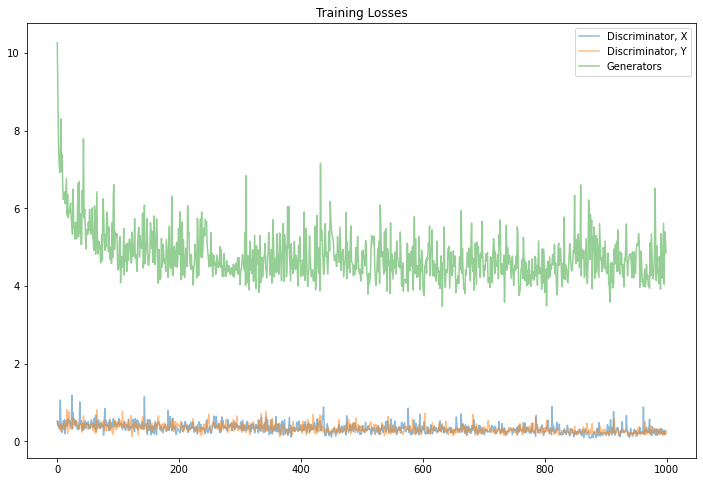

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/cycle-gan/notebook_images/sample-004000-summer2winter.png?raw=1' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [29]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


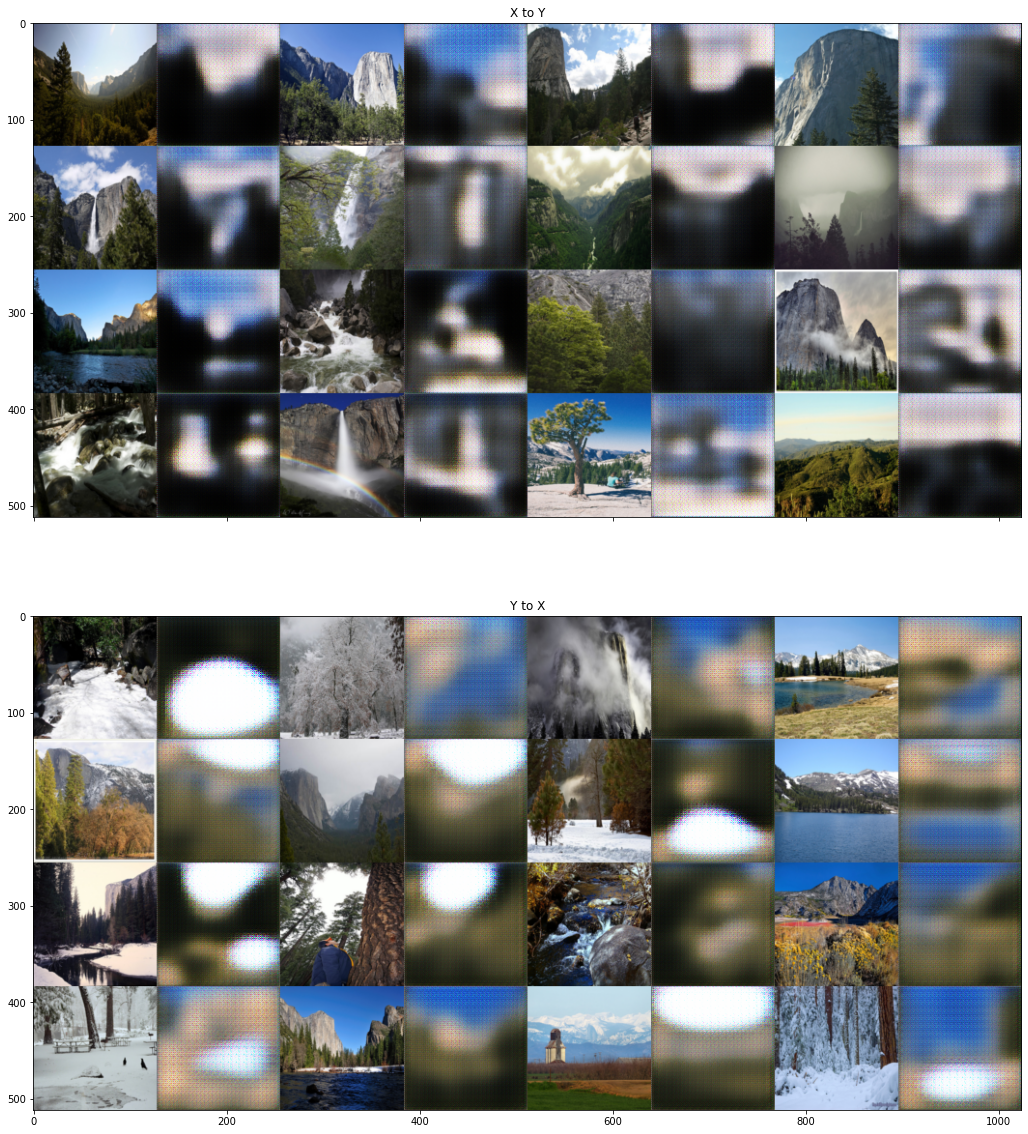

In [30]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

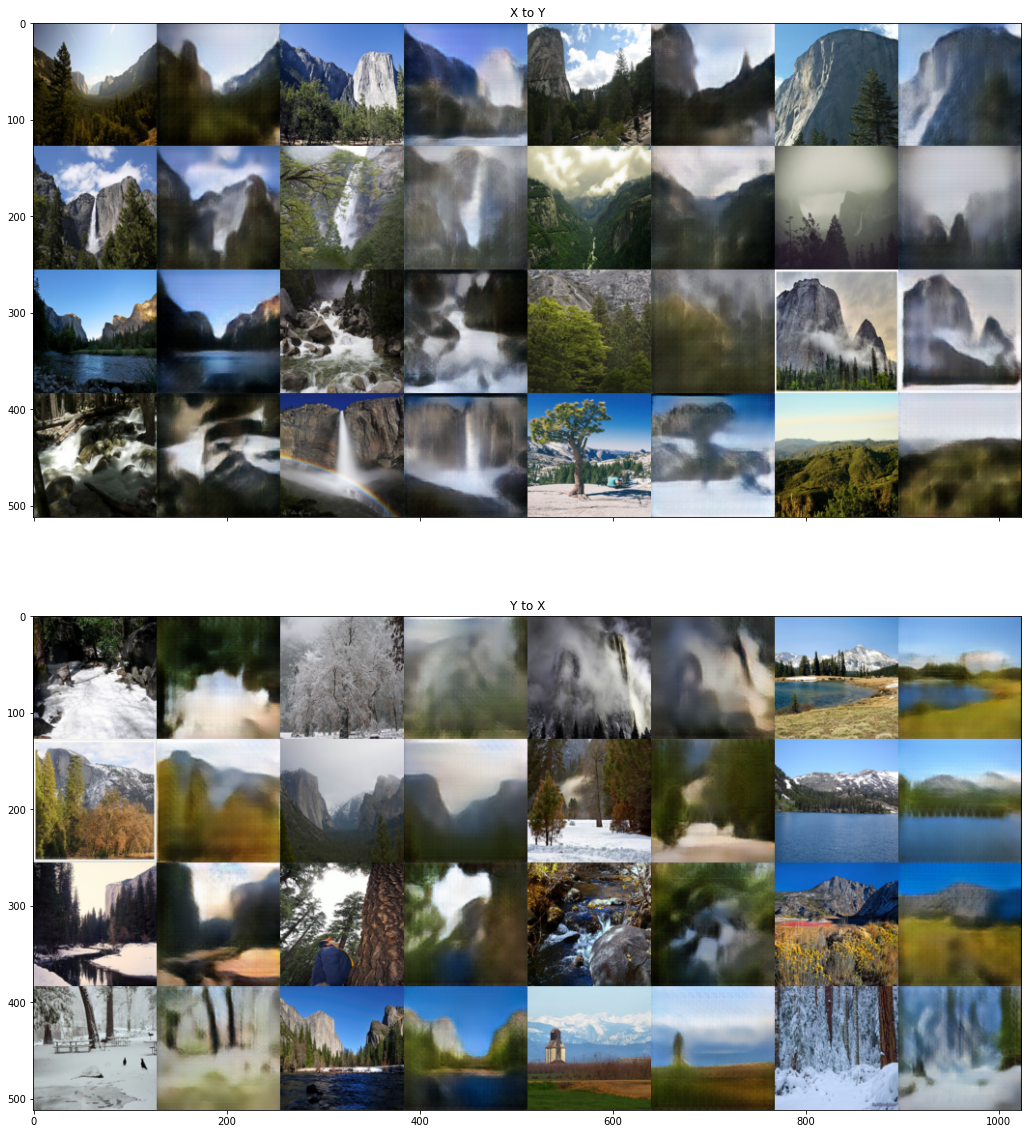

In [31]:
# view samples at iteration 10000
view_samples(10000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.